# Objective

The objective is to predict the `total_minutes` a order takes to complete, where the rows not containing a `total_minutes` value should be set aside as a part of the submission file, containing the `order_id` with the predicted values. 

As we are interested in seeing how you attacked the problem, we also ask you to include your code together with the submission file. The code needs to be well documented, explaining the decisions made. With these explanations, we will be looking at everything from how the data was processed, features used to the completed model and predictions. 

## Libraries

In [188]:
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from pygam import LinearGAM

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import plot_importance
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

# Helpers Function 
from helpers import haversine, plot_metrics, plot_feature_importance

## 1. Datasets

Esta primera parte está contemplada en la carga de la data por medio de los __archivos csv__ entregados, en cada segmento de carga de data por archivo se procederá a realizar algunos preprocesamiento, con el objetivo de tener un solo dataframe donde estará toda la data consolidada por orden de compra y con atributos generados que aportarán información al momento de modelar los datos por medio de un algoritmo de Machine Learning. 

#### 1.1. Order Products

In [2]:
# Loading Order Products dataset
order_products = pd.read_csv('data/order_products.csv', sep=',')
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [3]:
print("Cantidad de registros: ", order_products.shape[0])
print("Cantidad de atributos: ", order_products.shape[1])

Cantidad de registros:  198500
Cantidad de atributos:  4


No se encuentran valores perdidos dentro del dataset order products

In [4]:
order_products.isnull().any()

order_id      False
product_id    False
quantity      False
buy_unit      False
dtype: bool

Para esta ocasión se busca corroborar de que la cantidad de productos que estén en la orden de compra estos corresondan la unidad asociada que indica el atributo `buy_unit` si bien tenemos un id del producto se desconcoce en cuanto al nombre, con el fin de que no hayan productos que sean de tipo __UN__ y que la cantidad esté en decimal. Se crea una columna temporal con el nombre `check_unit`, donde aquí se podrá apreciar si existen valores decimales y que estén relacionados a __UN__.

No se encontró ninguna anomalía con respecto a la cantidad de productos asociadas con su respectiva unidad.

In [5]:
order_products['check_unit'] = np.where(order_products['buy_unit'] == 'KG', 1, order_products['quantity'])
order_products['check_unit'] = pd.to_numeric(order_products['check_unit'])

In [6]:
order_products['check_unit'].unique()

array([  1.,   2.,   8.,   6.,   3.,   5.,  10.,  12.,   4.,  14.,  20.,
         7.,   9.,  13.,  16.,  24.,  18.,  15.,  27.,  21.,  32.,  11.,
        50.,  30.,  26.,  28.,  29.,  36.,  23.,  25.,  60., 100.,  40.,
        35.,  64.,  70.,  22.])

Se crean nuevos atributos, los cuales están comprendidos por productos que son pesados y productos que no se necesitan pesar, se llamaran `to_weigh` y `no_weigh` respectivamente, para finalmente dejar un dataframe con la cantidad de productos que se pesan y no se pesan, más el total de productos por orden.

__Nota:__ Para la parte de productos que se pesan, en vez del total de `KG` por producto, diré que cada observaciónque esté contemplada con esta unidad de medida corresponderá a un producto, es decir, si el cliente pidió __3KG__ de limón, esto equivale a un producto que tiene dicho peso, el cual no considero, esto con el objetivo de tener la cantidad de productos pesados y que no se pesan.

In [7]:
 # Creating new columns
order_products['to_weigh'] = np.where(order_products['buy_unit'] == 'KG', 1, 0)
order_products['no_weigh'] = np.where(order_products['buy_unit'] == 'UN', order_products['quantity'], 0)

# Aggreate operation by "order_id"
order_products = order_products.groupby('order_id').sum().reset_index()

# Create new column called total_products
order_products['total_products'] = order_products['to_weigh'] + order_products['no_weigh']

# Group By and aggregate data
order_products = order_products.groupby('order_id').sum()

# dropping temporal column
order_products = order_products.drop(columns=['check_unit', 'quantity'])

In [8]:
order_products.shape

(9978, 3)

#### 1.2. Orders

In [9]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [10]:
print("La cantidad de registros es de: ", orders.shape[0])
print("La cantidad de atributos es de: ", orders.shape[1])

La cantidad de registros es de:  10000
La cantidad de atributos es de:  8


Existen valores perdidos en el atributo `total_minutes`, más adeleante se muestra la cantidad exacto de estos valores.

In [11]:
orders.isnull().any()

order_id           False
lat                False
lng                False
promised_time      False
on_demand          False
shopper_id         False
store_branch_id    False
total_minutes       True
dtype: bool

Tenemos algunos valores peridos en el atributo `total_minutes` (2000 registros) representando el __20%__ de las ordenes de compra, esto es de esperarse, debido a qué el objetivo del desafío es predecir el total de minutos para dichas ordenes. Se dejará tal cual el dataset y eventualmente se aislarán estos registros para dejarlos como data test. 

In [12]:
# Missig Values Table
total = orders.isnull().sum().sort_values(ascending=False)
percent = (orders.isnull().sum() / orders.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values

,Total,Percent(%)
total_minutes,2000,20.0
store_branch_id,0,0.0
shopper_id,0,0.0
on_demand,0,0.0
promised_time,0,0.0
lng,0,0.0
lat,0,0.0
order_id,0,0.0


En el siguiente gráfico se aprecia la cantidad de orden que se han entregado de acuerdo al tiempo estimado o prometido, para esta ocasión, la cantidad de pedidos entregados con respecto al tiempo estimado o prometido ha sido de __45%__ de efectividad, dejando con un __55%__ aquellos pedidos que por alguna razón no se entregaron en el tiempo prometido. 

__Importante:__ Mencionar que para esta categoría la cual influye en el tiempo a predecir no se aprecia un alto desbalance entre las categorías `False` y `True`.

In [13]:
orders['on_demand'].value_counts('%')

False    0.5453
True     0.4547
Name: on_demand, dtype: float64

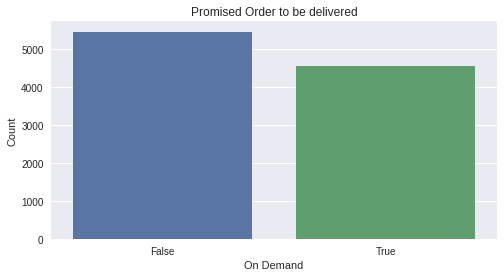

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(x='on_demand', data=orders)
plt.xlabel("On Demand")
plt.ylabel("Count")
plt.title("Promised Order to be delivered");

#### 1.3 Shoppers

In [15]:
shoppers = pd.read_csv('data/shoppers.csv', sep=',')
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [16]:
print("La cantidad de registros es de: ", shoppers.shape[0])
print("La cantidad de atributos es de: ", shoppers.shape[1])

La cantidad de registros es de:  2864
La cantidad de atributos es de:  6


In [17]:
shoppers.isnull().any()

shopper_id       False
seniority        False
found_rate        True
picking_speed    False
accepted_rate     True
rating            True
dtype: bool

Se aprecia que en este dataset tenemos 3 atributos que presentan valores perdidos, estos son `found_rate` __3.53%__, `rating` __2.93%__ y `accepted_rate` __0.94%__. Eventualmente en la sección de __Feature Engineering__ se procederá a imputar estos atributos para no eliminar data, ya que en total es como un __~6%__.

In [18]:
# Missing Values Table
total = shoppers.isnull().sum().sort_values(ascending=False)
percent = round((shoppers.isnull().sum() / shoppers.isnull().count() * 100), 2)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values

,Total,Percent(%)
found_rate,101,3.53
rating,84,2.93
accepted_rate,27,0.94
picking_speed,0,0.00
seniority,0,0.00
shopper_id,0,0.00


Se aprecia que para el atributo `seniority` existen 4 tipos de categoría que están identificadas por medio de un ID, en este caso se proceden a renombrar para hacer más amigable la lectura de los datos y el entendimiento de ellos.

__Nota:__ En esta ocasión la distribución de la categoría cuando se es shopper está identificada por medio de un código (anonimizada), para esta ocasión tomaré una hipótesis con respecto a la cantidad que tiene cada una y que categoría puede ser.

Indagando un poco por Internet sobre que categoría puede ser, he encontrado algunos nombres como `ADVANCED`, `INTERMEDIATE`, `BEGINNER` (estas 3 como principales) y una cuarta categoría `REVIEW` que asociaré como personas que estén interesados en ser shopper y que aún no han empezado.

In [19]:
shoppers['seniority'].value_counts()

6c90661e6d2c7579f5ce337c3391dbb9    1643
50e13ee63f086c2fe84229348bc91b5b     719
41dc7c9e385c4d2b6c1f7836973951bf     440
bb29b8d0d196b5db5a5350e5e3ae2b1f      62
Name: seniority, dtype: int64

La asignación del nombre de categoría por código la tomaré de mayor a menor, esto teniendo en cuenta la manera que ha crecido `Cornershop` en los últimos años, esto sería parte de mi hipótesis.

In [20]:
# Renaming seniority column values 
shopper_seniority = {'6c90661e6d2c7579f5ce337c3391dbb9': 'ADVANCED',
                     '50e13ee63f086c2fe84229348bc91b5b': 'INTERMEDIATE',
                     '41dc7c9e385c4d2b6c1f7836973951bf': 'BEGINNER',
                     'bb29b8d0d196b5db5a5350e5e3ae2b1f': 'REVIEW'}

shoppers['seniority'] = shoppers['seniority'].map(shopper_seniority)

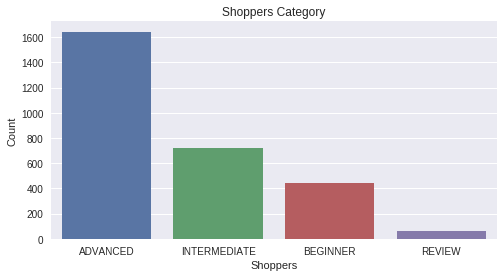

In [21]:
plt.figure(figsize=(8, 4))
sns.countplot(x='seniority', data=shoppers, order=shoppers['seniority'].value_counts().index)
plt.xlabel('Shoppers')
plt.ylabel('Count')
plt.title('Shoppers Category');

#### 1.4. Store

In [22]:
store = pd.read_csv('data/storebranch.csv', sep=',')
store.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


El dataset store no presenta valores perdidos, lo que es muy importante debido a que tenemos la longitud y latitud de la tienda, es decir, podríamos tener la dirección de la tienda.

In [23]:
store.isnull().any()

store_branch_id    False
store_id           False
lat                False
lng                False
dtype: bool

Se renombran las columnas `lat` y `lng` para diferenciales del daframe de orders que también tienen estas mismas columnas pero con respecto a laltitud y longitud de la locación de la entrega.

In [24]:
store.rename(columns=({'lat':'store_lat', 'lng':'store_lng'}), inplace=True)

#### 1.5. Consolidated Dataset

Se aplicará un merge al dataframe de orders para mantener la cantidad de pedidos u ordenes, para agregar información relevante a cada orden que se realizó, se debe tener en cuenta que este merge se hará progresivo para conectar con los atributos clave. 

In [25]:
# Mergin dataframes orders and orders_products
df = pd.merge(orders, order_products, how='inner', on='order_id')

In [26]:
# Merging orders with shoppers on "shopper_id"
df = pd.merge(df, shoppers, how='inner', on='shopper_id')

In [27]:
# Merging orders with store on "store_branch_id"
df = pd.merge(df, store, how='inner', on='store_branch_id')

Teniendo como resultado un dataset de 10.000 ordenes de compra con 21 atributos.

In [28]:
df.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,to_weigh,no_weigh,total_products,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,store_lat,store_lng
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,16.0,20.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
1,3bb5d9adb3ecac1925b60d5d26a510c4,-33.491167,-70.571649,2019-10-19 16:57:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,160.336211,4,63.0,67.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
2,b838eea64cf24dde0a78ce1feb84ca7c,-33.493406,-70.594164,2019-10-19 16:00:00+00:00,False,cb5ef07d15fb3981eeb6e0011bc80163,65ded5353c5ee48d0b7d48c591b8f430,122.239210,1,155.0,156.0,ADVANCED,0.8909,1.17,0.96,5.00,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
3,2c85303190a77493348b0b827232f4d6,-33.487836,-70.572412,2019-10-19 19:00:00+00:00,False,ca54a789a8dc54742710490e25df9844,65ded5353c5ee48d0b7d48c591b8f430,133.113926,8,115.0,123.0,ADVANCED,0.8462,1.11,0.96,4.96,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
4,e606cc26b843c312df82a29d1f8d4372,-33.504759,-70.552168,2019-10-19 00:00:00+00:00,False,362e274d254be8fae76396b8f10a7fd5,65ded5353c5ee48d0b7d48c591b8f430,94.734479,3,97.0,100.0,INTERMEDIATE,0.8138,1.89,0.84,4.68,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925


## 2. Feature Engineering

En esta etapa se desarrollará toda la parte de pre-procesamiento, transformaciones y feature engineering, que nos ayudarán a enriquecer los datos al momento de modelarlos. También se crea un archivo llamado `helpers.py` en el cual se irán agregando funciones y llamarlas desde el notebook, esto con el objetivo de no "ensuciar" la redacción y el código. 

In [29]:
# Making copy of final dataframe
orders = df.copy()
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,to_weigh,no_weigh,total_products,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,store_lat,store_lng
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,16.0,20.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
1,3bb5d9adb3ecac1925b60d5d26a510c4,-33.491167,-70.571649,2019-10-19 16:57:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,160.336211,4,63.0,67.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
2,b838eea64cf24dde0a78ce1feb84ca7c,-33.493406,-70.594164,2019-10-19 16:00:00+00:00,False,cb5ef07d15fb3981eeb6e0011bc80163,65ded5353c5ee48d0b7d48c591b8f430,122.239210,1,155.0,156.0,ADVANCED,0.8909,1.17,0.96,5.00,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
3,2c85303190a77493348b0b827232f4d6,-33.487836,-70.572412,2019-10-19 19:00:00+00:00,False,ca54a789a8dc54742710490e25df9844,65ded5353c5ee48d0b7d48c591b8f430,133.113926,8,115.0,123.0,ADVANCED,0.8462,1.11,0.96,4.96,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
4,e606cc26b843c312df82a29d1f8d4372,-33.504759,-70.552168,2019-10-19 00:00:00+00:00,False,362e274d254be8fae76396b8f10a7fd5,65ded5353c5ee48d0b7d48c591b8f430,94.734479,3,97.0,100.0,INTERMEDIATE,0.8138,1.89,0.84,4.68,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925


In [30]:
orders.isnull().any()

order_id           False
lat                False
lng                False
promised_time      False
on_demand          False
shopper_id         False
store_branch_id    False
total_minutes       True
to_weigh           False
no_weigh           False
total_products     False
seniority          False
found_rate          True
picking_speed      False
accepted_rate       True
rating              True
store_id           False
store_lat          False
store_lng          False
dtype: bool

Antes de realizar el análisis exploratorio y posteriormente el descriptivo, se debe calcluar la distancia entre la dirección del pedido u orden y la locación de la tienda. Nuestro dataset consolidado está constituido por latitudes y longitudes tanto de los pedidos como de las tiendas, estos datos están anonimizados por lo que no se conoce la locación exacta de cada uno, por tal motivo se calculará la distancia entre los 2 puntos por medio de la fórmula `Haversine` y obtener el resultado en __KM__ para trabajar con este resultado.

Para hacer el cálculo de la distancia se reviso la documentación de Scikit-Learn, para extraer la fórmula de la distancia y crear una función [Doc Haversine](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

![Haversine Formula](https://macalupu.com/wp-content/uploads/2019/03/haversineFormula.png)

In [31]:
# Calculating distance between order and store location
orders['distance'] = orders.apply(lambda x: haversine(x['lat'], x['lng'], x['store_lat'], x['store_lng']), axis=1)

# Dropping lat and lng columns
orders.drop(columns=['lat', 'lng', 'store_lat', 'store_lng'], inplace=True)
orders.head()

,order_id,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,to_weigh,no_weigh,total_products,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,distance
0,e750294655c2c7c34d83cc3181c09de4,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,16.0,20.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,1.823025
1,3bb5d9adb3ecac1925b60d5d26a510c4,2019-10-19 16:57:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,160.336211,4,63.0,67.0,ADVANCED,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,0.961905
2,b838eea64cf24dde0a78ce1feb84ca7c,2019-10-19 16:00:00+00:00,False,cb5ef07d15fb3981eeb6e0011bc80163,65ded5353c5ee48d0b7d48c591b8f430,122.239210,1,155.0,156.0,ADVANCED,0.8909,1.17,0.96,5.00,c4ca4238a0b923820dcc509a6f75849b,1.652014
3,2c85303190a77493348b0b827232f4d6,2019-10-19 19:00:00+00:00,False,ca54a789a8dc54742710490e25df9844,65ded5353c5ee48d0b7d48c591b8f430,133.113926,8,115.0,123.0,ADVANCED,0.8462,1.11,0.96,4.96,c4ca4238a0b923820dcc509a6f75849b,0.694901
4,e606cc26b843c312df82a29d1f8d4372,2019-10-19 00:00:00+00:00,False,362e274d254be8fae76396b8f10a7fd5,65ded5353c5ee48d0b7d48c591b8f430,94.734479,3,97.0,100.0,INTERMEDIATE,0.8138,1.89,0.84,4.68,c4ca4238a0b923820dcc509a6f75849b,3.316283


Recodifico la columna `on_demand`, ya que es booleana y la convierto en númerica para modelar los datos eventualmente. 

In [32]:
# Recoding on_demand column, when 1 is equal False and 0 is True
orders['on_demand'] = np.where(orders['on_demand'] == False, 1, 0)

In [33]:
# Missig Values Table
total = orders.isnull().sum().sort_values(ascending=False)
percent = (orders.isnull().sum() / orders.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values.head()

,Total,Percent(%)
total_minutes,1995,19.993987
found_rate,199,1.994388
rating,162,1.623572
accepted_rate,46,0.461014
distance,0,0.000000


Para enriquecer más los datos y posteriormente hacer análisis descriptivos con mayor profundidad, tomé `promised_time` y lo separé por `hora`, `día`, `mes` y `weekday`, con el objetivo de entender mucho más la entrega de la orden de compra.

In [34]:
orders['timestamp'] = orders['promised_time'].apply(lambda x: pd.to_datetime(x.split('+')[0]))
orders['hour'] = orders['timestamp'].apply(lambda x: x.hour)
orders['day'] = orders['timestamp'].apply(lambda x: x.day)
orders['month'] = orders['timestamp'].apply(lambda x: x.month)
orders['weekday'] = orders['timestamp'].apply(lambda x: x.weekday())

Elimino algunos atributos, no los considero importante al momento de modelar, en esta ocasión no me quiero enfocar en datos como la cantidad de entregas por shopper y/o la cantidad de tiendas que haya en el dataset. 

In [35]:
# Removing some columns that irrelevant, ''
orders.drop(columns=['shopper_id', 'store_branch_id', 
                     'store_id', 'timestamp'], inplace=True)

Antes de modelar los datos voy a dejar la data total en un dataframe que no contendrá ningún tipo de imputación y otro donde si tendrá imputaciones con respecto a los atributos antes mencionados. Esto con el objetivo de modelar de 2 maneras para saber que tan bien se comportan los datos al momento de implementar los algoritmos de `Machine Learning`.

__Nota:__ El atributo `total_minutes` no será imputado, este es el vector objetivo a predecir.

In [36]:
# Total datafame without imputation
orders_no_imp = orders.copy()

__Analizamos los atributos a imputar__

Aislaré los `NaN` de cada uno de los atributos a imputar `found_rate`, `accepted_rate` y `rating`. El objetivo es tener la media del atributo que tiene los valores perdidos, estos valores se obtendrán agrupando `seniority` del shopper y que realice el cálculo correspondiente.

In [37]:
# Orders imputation Dataframe
orders_imp = orders.copy()

In [38]:
# Missing Values Dataframes
mv_df_fr = orders_imp[orders_imp['found_rate'].isnull()]
mv_df_ar = orders_imp[orders_imp['accepted_rate'].isnull()]
mv_df_ra = orders_imp[orders_imp['rating'].isnull()]

Las categorías del shopper que se encuentran en los dataframes con valores perdidos son `REVIEW`, `INTERMEDIATE` y ` BEGINNER` para `found_rate`, para `accepted_rate` están `REVIEW`, `INTERMEDIATE` y para `rating` están `REVIEW`, `INTERMEDIATE`, ` BEGINNER` y `ADVANCED`. Se obtiene la media de cada atributo con valores perdido por medio de la agrupación `seniority`, con el objetivo de posteriormente hacer una imputación en cuanto a la media por categoría del shopper y no imputar por la media del atributo de manera global.

In [39]:
mv_df_fr['seniority'].value_counts()

REVIEW          102
INTERMEDIATE     72
BEGINNER         25
Name: seniority, dtype: int64

In [40]:
mv_df_ar['seniority'].value_counts()

REVIEW          38
INTERMEDIATE     8
Name: seniority, dtype: int64

In [41]:
mv_df_ra['seniority'].value_counts()

REVIEW          95
INTERMEDIATE    62
BEGINNER         3
ADVANCED         2
Name: seniority, dtype: int64

In [42]:
# Calculating mean found_rate
mean_found_rate = orders_imp.groupby('seniority')['found_rate'].mean()
mean_found_rate

seniority
ADVANCED        0.871571
BEGINNER        0.847772
INTERMEDIATE    0.850373
REVIEW          0.848467
Name: found_rate, dtype: float64

In [43]:
# Calculating mean accepted_rate
mean_accepted_rate = orders_imp.groupby('seniority')['accepted_rate'].mean()
mean_accepted_rate

seniority
ADVANCED        0.957517
BEGINNER        0.939649
INTERMEDIATE    0.792811
REVIEW          0.787455
Name: accepted_rate, dtype: float64

In [44]:
# Calculating mean rating
mean_rating = orders_imp.groupby('seniority')['rating'].mean()
mean_rating

seniority
ADVANCED        4.846534
BEGINNER        4.867109
INTERMEDIATE    4.844785
REVIEW          4.868636
Name: rating, dtype: float64

In [45]:
# Imputating missing values per columns 

# Found Rate
orders_imp['found_rate'] = np.where((orders_imp['seniority'] == 'INTERMEDIATE') & 
                                      (orders_imp['found_rate'].isnull()), 0.850373, orders_imp['found_rate'])

orders_imp['found_rate'] = np.where((orders_imp['seniority'] == 'REVIEW') & 
                                      (orders_imp['found_rate'].isnull()), 0.848467, orders_imp['found_rate'])

orders_imp['found_rate'] = np.where((orders_imp['seniority'] == 'BEGINNER') & 
                                      (orders_imp['found_rate'].isnull()), 0.847772, orders_imp['found_rate'])

# Accepted Rate
orders_imp['accepted_rate'] = np.where((orders_imp['seniority'] == 'INTERMEDIATE') & 
                                      (orders_imp['accepted_rate'].isnull()), 0.792811, orders_imp['accepted_rate'])

orders_imp['accepted_rate'] = np.where((orders_imp['seniority'] == 'REVIEW') & 
                                      (orders_imp['accepted_rate'].isnull()), 0.787455, orders_imp['accepted_rate'])


# Rating
orders_imp['rating'] = np.where((orders_imp['seniority'] == 'INTERMEDIATE') & 
                                      (orders_imp['rating'].isnull()), 4.844785, orders_imp['rating'])

orders_imp['rating'] = np.where((orders_imp['seniority'] == 'REVIEW') & 
                                      (orders_imp['rating'].isnull()), 4.868636, orders_imp['rating'])

orders_imp['rating'] = np.where((orders_imp['seniority'] == 'BEGINNER') & 
                                      (orders_imp['rating'].isnull()), 4.867109, orders_imp['rating'])

orders_imp['rating'] = np.where((orders_imp['seniority'] == 'ADVANCED') & 
                                      (orders_imp['rating'].isnull()), 4.846534, orders_imp['rating'])

Aplicando `One Hot Encoding` a dos atributos `seniority` y `weekday`, estos atributos no son ordinales por lo que aplico esta técnica para evitar una relación ordinal en dichos atributos, mantendré la columna `day` para más adelante realizar el análisis exploratoria, en este proceso de binarización o `dummy_variables` elimino la primera columna que se genera, para evitar la colinealidad, es decir, que un atributo sea la combinación líneal de otro. 

Renombro los días que están dentro del atributo `weekday`, cabe mencionar que de acuerdo a la documentación de la función, los días de la semana están comprendido de la siguiente manera:

| Integer Value | Day of the week |
| -- | -- |
| 0 | Monday |
| 1 | Tuesday |
| 2 | Wendsday |
| 3 | Thursday |
| 4 | Friday |
| 5 | Saturday |
| 6 | Sunday |

Los pedidos se realizar mayormente los sábados, seguido de los viernes y un solo pedido realizado el día domingo, en el análisis explorattorio se indagará más.

In [46]:
orders_imp['weekday'].value_counts()

5    7076
4    2901
6       1
Name: weekday, dtype: int64

In [47]:
orders_imp['weekday2'] = orders_imp['weekday'] # temporal column
orders_imp = pd.get_dummies(orders_imp, columns=['weekday'],
                            prefix=['weekday'], prefix_sep='_', drop_first=False)

orders_imp.rename(columns=({'weekday_4':'friday', 'weekday_5':'saturday', 'weekday_6':'sunday'}), inplace=True)
orders_imp.drop(columns=['sunday'], inplace=True, axis=1)


orders_no_imp['weekday2'] = orders_no_imp['weekday'] # temporal column
orders_no_imp = pd.get_dummies(orders_no_imp, columns=['weekday'],
                            prefix=['weekday'], prefix_sep='_', drop_first=False)

orders_no_imp.rename(columns=({'weekday_4':'friday', 'weekday_5':'saturday', 'weekday_6':'sunday'}), inplace=True)
orders_no_imp.drop(columns=['sunday'], inplace=True, axis=1)

In [48]:
orders_imp.head()

,order_id,promised_time,on_demand,total_minutes,to_weigh,no_weigh,total_products,seniority,found_rate,picking_speed,accepted_rate,rating,distance,hour,day,month,weekday2,friday,saturday
0,e750294655c2c7c34d83cc3181c09de4,2019-10-18 20:48:00+00:00,0,67.684264,4,16.0,20.0,ADVANCED,0.9024,1.30,0.92,4.76,1.823025,20,18,10,4,1,0
1,3bb5d9adb3ecac1925b60d5d26a510c4,2019-10-19 16:57:00+00:00,0,160.336211,4,63.0,67.0,ADVANCED,0.9024,1.30,0.92,4.76,0.961905,16,19,10,5,0,1
2,b838eea64cf24dde0a78ce1feb84ca7c,2019-10-19 16:00:00+00:00,1,122.239210,1,155.0,156.0,ADVANCED,0.8909,1.17,0.96,5.00,1.652014,16,19,10,5,0,1
3,2c85303190a77493348b0b827232f4d6,2019-10-19 19:00:00+00:00,1,133.113926,8,115.0,123.0,ADVANCED,0.8462,1.11,0.96,4.96,0.694901,19,19,10,5,0,1
4,e606cc26b843c312df82a29d1f8d4372,2019-10-19 00:00:00+00:00,1,94.734479,3,97.0,100.0,INTERMEDIATE,0.8138,1.89,0.84,4.68,3.316283,0,19,10,5,0,1


Una vez imputados todos los atributos no tenemos valores perdidos a excepción de `total_minutes` que es el tiempo que se buscar predecir para esas ordenes.

In [49]:
orders_imp.isnull().any()

order_id          False
promised_time     False
on_demand         False
total_minutes      True
to_weigh          False
no_weigh          False
total_products    False
seniority         False
found_rate        False
picking_speed     False
accepted_rate     False
rating            False
distance          False
hour              False
day               False
month             False
weekday2          False
friday            False
saturday          False
dtype: bool

## 3. Exploratory Data Analisis (EDA)

Creo nuevos dataframes con respecto al atributo `on_demand`, sabemos que `Cornershop` cumple con __45%__ al momento de entregar los pedidos de acuerdo al tiempo estimado, dejando un __55%__ de incumplimiento. El objetivo de esta segmentación es conocer la distribución del tiempo cuando `Cornershop` se compremete con el tiempo estimado y cumple con esto.

In [50]:
df_eda = orders_no_imp[orders_no_imp[['total_minutes', 'found_rate', 'accepted_rate', 'rating']].notnull().all(1)]

In [51]:
on_demand_true = df_eda[df_eda['on_demand'] == 0]
on_demand_false = df_eda[df_eda['on_demand'] == 1]

In [52]:
on_demand_true.describe()

,on_demand,total_minutes,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,hour,day,month,weekday2,friday,saturday
count,3521.0,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.0,3521.000000,3521.000000,3521.000000
mean,0.0,71.141581,1.467481,28.238001,29.705481,0.864447,1.718108,0.916791,4.849324,2.887048,17.275490,18.454700,10.0,4.454700,0.545300,0.454700
std,0.0,28.578123,1.780938,26.073501,26.791342,0.030504,0.665791,0.094617,0.127708,2.024430,6.364559,0.498014,0.0,0.498014,0.498014,0.498014
min,0.0,18.192689,0.000000,0.000000,1.000000,0.737300,0.730000,0.280000,3.880000,0.076491,0.000000,18.000000,10.0,4.000000,0.000000,0.000000
25%,0.0,50.744762,0.000000,9.000000,10.000000,0.846900,1.250000,0.880000,4.800000,1.483329,16.000000,18.000000,10.0,4.000000,0.000000,0.000000
50%,0.0,66.709362,1.000000,21.000000,22.000000,0.867700,1.550000,0.960000,4.880000,2.429380,20.000000,18.000000,10.0,4.000000,1.000000,0.000000
75%,0.0,85.814803,2.000000,39.000000,41.000000,0.884900,2.000000,1.000000,4.960000,3.850046,21.000000,19.000000,10.0,5.000000,1.000000,1.000000
max,0.0,303.029792,13.000000,286.000000,289.000000,0.964700,5.980000,1.000000,5.000000,16.672771,23.000000,19.000000,10.0,5.000000,1.000000,1.000000


In [53]:
on_demand_false.describe()

,on_demand,total_minutes,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,hour,day,month,weekday2,friday,saturday
count,4281.0,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.0,4281.000000,4281.000000,4281.000000
mean,1.0,89.338376,2.065639,40.129876,42.195515,0.862669,1.642621,0.920562,4.851710,2.882062,14.871993,18.923616,10.0,4.923616,0.076618,0.923149
std,0.0,36.889648,2.297019,37.211839,38.201793,0.029154,0.596775,0.091247,0.126588,1.638559,6.365133,0.266521,0.0,0.266521,0.266015,0.266386
min,1.0,11.969489,0.000000,0.000000,1.000000,0.742900,0.650000,0.240000,3.880000,0.080963,0.000000,18.000000,10.0,4.000000,0.000000,0.000000
25%,1.0,61.571741,0.000000,13.000000,14.000000,0.845900,1.250000,0.880000,4.800000,1.677679,14.000000,19.000000,10.0,5.000000,0.000000,1.000000
50%,1.0,84.389768,1.000000,31.000000,33.000000,0.864900,1.490000,0.960000,4.880000,2.580974,17.000000,19.000000,10.0,5.000000,0.000000,1.000000
75%,1.0,112.003251,3.000000,56.000000,59.000000,0.882400,1.870000,1.000000,4.960000,3.934550,19.000000,19.000000,10.0,5.000000,0.000000,1.000000
max,1.0,304.190303,16.000000,317.000000,319.000000,0.971000,7.040000,1.000000,5.000000,16.347413,23.000000,20.000000,10.0,6.000000,1.000000,1.000000


El siguiente gráfico muestra la distribución con respecto al promedio de minutos cuando `Cornershop` estima un tiempo de entrega y lo cumple, teniendo como resultado el promedio de pedidos entregados con __71min__.

Tenemos algunos casos anomalos que salen un poco de como está distribuido el tiempo con respecto a las ordenes, se aprecia en el gráfico como hay una cola hacia la derecha cuando es mayor a __200min__, con un total de 5 observaciones y en porcentaje es de __0.001%__.

In [54]:
a_ondemand_true = on_demand_true[on_demand_true['total_minutes'] > 200]
print("Cantidad de entregas que se cumplen mayor a 200 minutos: ", a_ondemand_true.shape[0])
print("Porcentaje de entregas que se cumplen mayor a 200 minutos: ", (a_ondemand_true.shape[0] / on_demand_true.shape[0]))

Cantidad de entregas que se cumplen mayor a 200 minutos:  5
Porcentaje de entregas que se cumplen mayor a 200 minutos:  0.0014200511218403862


In [55]:
mean_time_od_true = np.mean(on_demand_true['total_minutes'])
print("Tiempo promedio de entrega: ", mean_time_od_true)

Tiempo promedio de entrega:  71.1415805744012


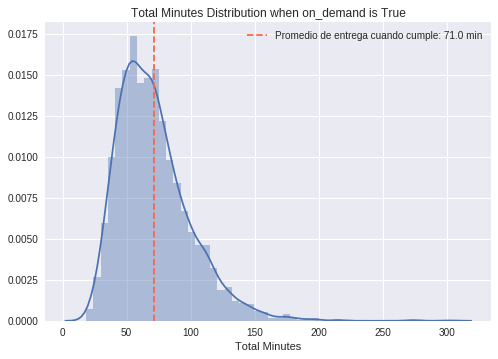

In [56]:
sns.distplot(on_demand_true['total_minutes'], kde=True)
plt.axvline(np.mean(on_demand_true['total_minutes']), 
            color='tomato', ls='--',
            label="Promedio de entrega cuando cumple: {0} min".format(round(mean_time_od_true)))
plt.xlabel("Total Minutes")
plt.title("Total Minutes Distribution when on_demand is True")
plt.legend();

Cuando `Cornershop` estima un tiempo y no cumple tenemos un promedio de __89min__, era de esperarse, por como está distribuido el atributo `on_demand`con el __55%__ de incumplimiento, también se logra apreciar como existen algunos pedidos que se incumplen mayor a __200min__, saliendo un poco de la distribución normal de los datos con respecto a `total_minutes`, esto se representa en 28 entregas incumplidas que equivalen a un __0.06%__.

Ahora bien, como se conoce el promedio de tiempo cuando cumplimos con la entrega en el tiempo estimado y también conocemos el promedio de enrega cuando incumplimos con dicho tiempo, se puede considrear un __benchmark__ en tiempo(minutos) para el atributo `on_demand`, es decir, de que cuando este sea `True` la entrega se realizará en menos de __90min__, ¿por qué 90 minutos? esto se debe a como dije anteriormente el promedio de incumplimiento al entregar es de __89min__, entonces, redondeo esta cantidad de minutos para tener un tiempo más afable al momento de notificar al cliente por la app, este tiempo se puede expresar en horas que serían `1,5hrs`.

__Nota:__ Cuando el cliente en la app elija `on_demand` este tiempo de entrega será de __90min__ y por otra parte sino toma `on_demand`, se puede clasificar como un pedido dentro de una franja horaria.

In [57]:
a_ondemand_false = on_demand_false[on_demand_false['total_minutes'] > 200]
print("Cantidad de entregas que se incumplen mayor a 200 minutos: ", a_ondemand_false.shape[0])
print("Porcentaje de entregas que se incumplen mayor a 200 minutos: ", (a_ondemand_false.shape[0] / on_demand_false.shape[0]))

Cantidad de entregas que se incumplen mayor a 200 minutos:  27
Porcentaje de entregas que se incumplen mayor a 200 minutos:  0.006306937631394534


In [58]:
mean_time_od_false = np.mean(on_demand_false['total_minutes'])
print("Tiempo promedio de incumplimiento de entrega: ", mean_time_od_false)

Tiempo promedio de incumplimiento de entrega:  89.33837601668223


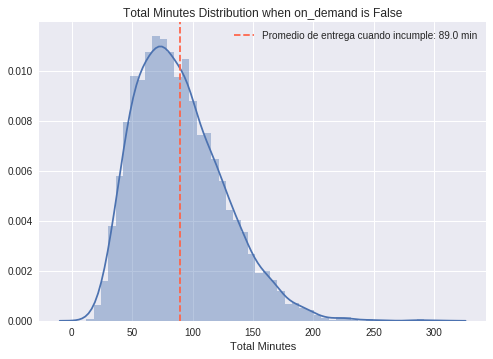

In [59]:
sns.distplot(on_demand_false['total_minutes'])
plt.axvline(mean_time_od_false,
            color='tomato', ls='--',
            label='Promedio de entrega cuando incumple: {0} min'.format(round(mean_time_od_false)))
plt.xlabel("Total Minutes")
plt.title("Total Minutes Distribution when on_demand is False")
plt.legend();

#### Distribución de los KMs

El promedio de KMs para hacer una entrega de una orden es de `2.88KM` de manera global, la distancia está distribuida en su mayoría de 0 a 5KM, hay algunos outliers como se aprecian en el gráfico, estos están después de 7.5KM

In [60]:
mean_km = np.mean(df_eda['distance'])

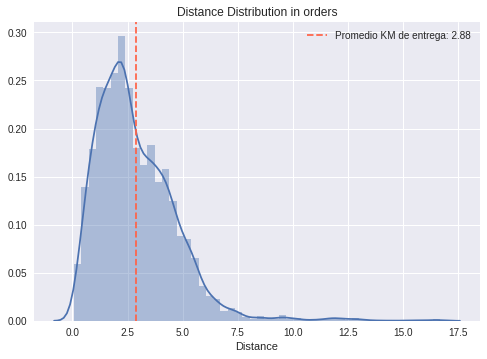

In [61]:
sns.distplot(df_eda['distance'])
plt.axvline(mean_km, color='tomato', ls='--', label='Promedio KM de entrega: {0}'.format(round((mean_km), 2)))
plt.xlabel("Distance")
plt.title("Distance Distribution in orders")
plt.legend();

En el siguiente gráfico se aprecia como existe una leve correlación positiva entre la distancia y el total de minutos, se observa que a mayor distancia el tiempo crece, veamos si otros atributos tienen un mayor impacto.

Distance Vs Total Minutes


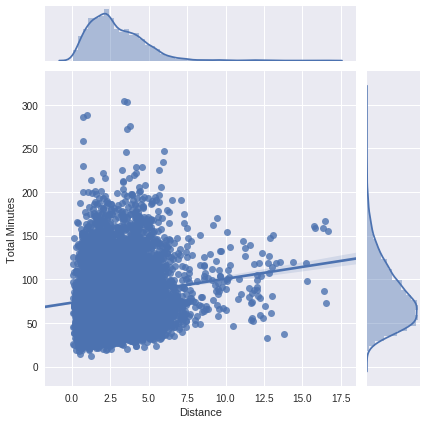

In [62]:
print("Distance Vs Total Minutes")
sns.jointplot(y='total_minutes', x='distance', data=df_eda, kind="reg")
plt.xlabel("Distance")
plt.ylabel("Total Minutes");

A diferencia del gráfico anterior, se puede apreciar como la relación entre ambos atributos tiende a una regresión lineal mucho más marcada, claramente, se observa que a medida que la persona compre más productos el tiempo aumenta considerablemente.

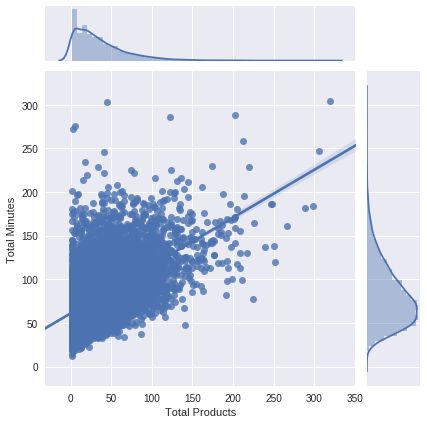

In [63]:
sns.jointplot(y='total_minutes', x='total_products', data=df_eda, kind="reg")
plt.xlabel("Total Products")
plt.ylabel("Total Minutes");

A diferencia de los 2 gráficos anteriores, existe una leve regresión que tiende hacer negativa, se observa que el `rating` del shopper no influye mucho, se puede deducir que los shopper independientemente de su `rating` están trabajando arduamente con cada pedido.

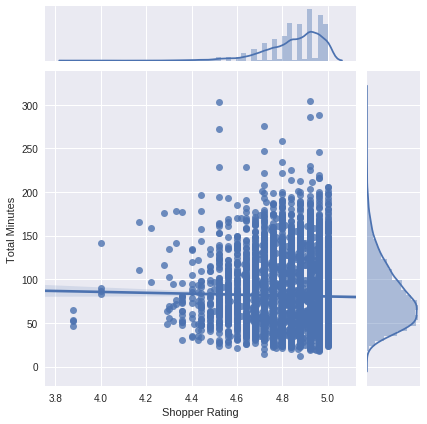

In [64]:
sns.jointplot(y='total_minutes', x='rating', data=df_eda, kind='reg')
plt.xlabel("Shopper Rating")
plt.ylabel("Total Minutes");

El promedio `rating` de los shoppers es de __4.85__, muy bueno en relación a la escala (1-5) que son  evaluados por los clientes, se puede apreciar la dedicación y esfuerzo que tienen para entregar un pedido en el tiempo estimado, a pesar de que haya una tasa de incumpliento del __55%__. Importante mencionar que el rating más bajo es de __3.8__.

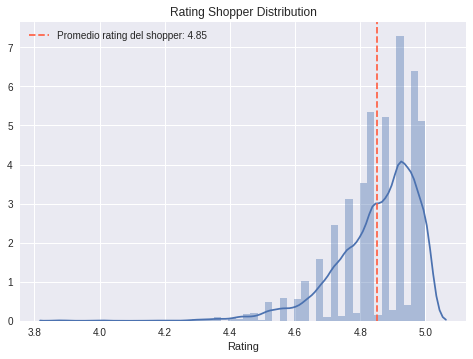

In [65]:
sns.distplot(df_eda['rating'])
plt.axvline(np.mean(df_eda['rating']), color='tomato', ls='--',
            label='Promedio rating del shopper: {0}'.format(round(np.mean(df_eda['rating']), 2)))
plt.xlabel("Rating")
plt.title("Rating Shopper Distribution")
plt.legend();

El promedio total de productos por orden es de aproximada 37 productos, no es una cantidad tan bajo con respecto a la distribución del atributo, este número es importante para tener en cuenta al momento de realizar estrategias.

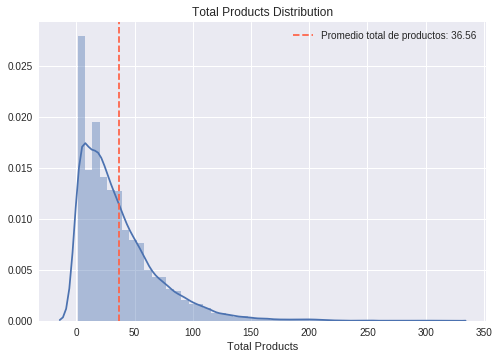

In [66]:
sns.distplot(df_eda['total_products'])
plt.axvline(np.mean(df_eda['total_products']), color='tomato', ls='--',
            label='Promedio total de productos: {0}'.format(round(np.mean(df_eda['total_products']), 2)))
plt.xlabel("Total Products")
plt.title("Total Products Distribution")
plt.legend();

Los clientes en sus ordenes de compra o pedidos mayormente el tipo de producto que compra son lo que se requieren pesar con __64%__ por orden y un __36%__ corresponden aquellos productos que se venden por unidad. Los datos del atributo `type_product` corresponde a __1: requiere pesar (KG)__ y __0: no requiere pesar (UN)__.

Teniendo en cuenta esta información se aprecia que las personas tienden a comprar más productos como frutas, verduras y proteínas, por lo que es un dato relevante para compartir con las empresas suscritas en `Cornershop`, a este nivel de información pueden realizar más estrategias digitales para ofertas o promociones a los clientes, donde eventualmente se podría tener una segmentación de clientes y analizar su comportamiento y extraer patrones. Cabe destacar, que los tipos de producto que se necesitan nombrados anteriormente es una hipótesis, ya que conocemos el código del producto pero que para mi conocimiento este es anonimizado, lo que significa que eventualmente podría hacer un cruce de información donde estén los nombres de los productos.

In [67]:
df_eda['type_product'] = np.where(df_eda['to_weigh'] >=1, 1, 0)
df_eda['type_product'].value_counts('%')

1    0.636375
0    0.363625
Name: type_product, dtype: float64

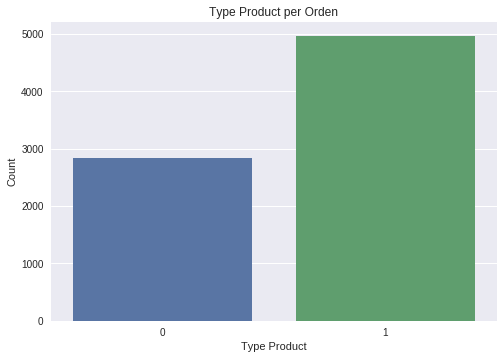

In [68]:
sns.countplot(df_eda['type_product'])
plt.xlabel("Type Product")
plt.ylabel("Count")
plt.title("Type Product per Orden");

El gráfico ademas nos muestra que aquellas compras que tienen productos que se deben pesar, tienen una distribución diferente a aquellos en los que no se pide ningun producto de pesaje, siendo su promedio mayor en aquellos que deben ser pesados. Se logra apreciar que en las compras con una cantidad hasta 10 productos, predomina los productos que no se pesan, es decir, estas compras chicas mayormente son productos por unidad, por otra parte, a medida que la cantidad de productos de una orden aumenta, los productos por unidad empiezan a decrecer y aumentan los productos que deben ser pesados.

<Figure size 864x504 with 0 Axes>

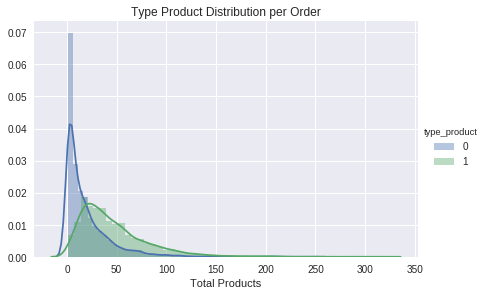

In [69]:
plt.figure(figsize=(12, 7))
g = sns.FacetGrid(df_eda, hue="type_product", size=4, aspect=1.5)
g = g.map(sns.distplot, "total_products")
g.add_legend()
plt.xlabel("Total Products")
plt.title("Type Product Distribution per Order");

In [70]:
print("Promedio de productos por orden que requieren ser pesados: ", 
      round(df_eda.query("type_product==1")['total_products'].mean(), 2))

print("Promedio de productos por orden que no requieren ser pesados: ", 
      round(df_eda.query("type_product==0")['total_products'].mean(), 2))

Promedio de productos por orden que requieren ser pesados:  46.26
Promedio de productos por orden que no requieren ser pesados:  19.58


Aquí podemos apreciar las horas en que `Cornershop` se comprometió a entregar el pedido de acuerdo al tiempo estimado al usuario, siendo las __20 HRS__ donde más se entregaron dichos pedidos, con un porcentaje de entrega del __11%__, por otra parte, se observa un rango en el cual se han hecho la entrega, claramente, desde las __14 y  23 horas__.

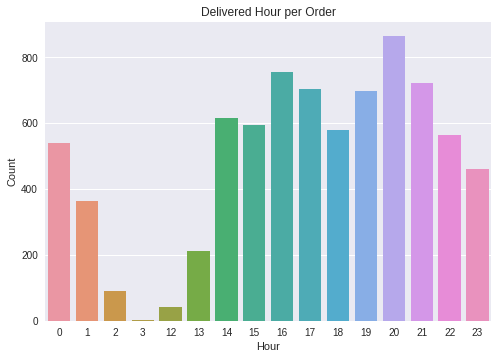

In [71]:
sns.countplot(df_eda['hour'])
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Delivered Hour per Order");

In [72]:
df_eda['hour'].value_counts('%')

20    0.110741
16    0.096898
21    0.092412
17    0.089977
19    0.089336
14    0.078826
15    0.076134
18    0.074340
22    0.072417
0     0.068957
23    0.059087
1     0.046783
13    0.027301
2     0.011407
12    0.005255
3     0.000128
Name: hour, dtype: float64

Con respecto a los días de entrega, el dataset contiene solamente 2 días, como fecha mínima "2019-10-18 19:01:00" y como fecha máxima "2019-10-20 00:00:00". Posterior a este gráfico veremos a que días de la semana correspondeme cada uno de ellos.

In [73]:
min(df_eda['promised_time']), max(df_eda['promised_time'])

('2019-10-18 19:01:00+00:00', '2019-10-20 00:00:00+00:00')

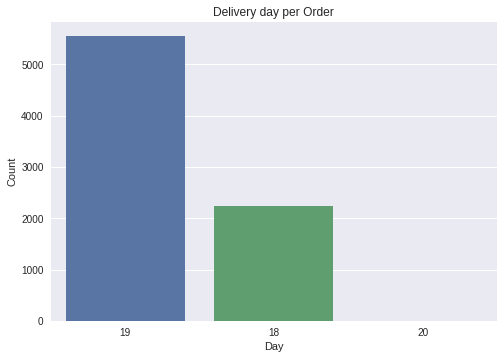

In [74]:
sns.countplot(x='day', data=df_eda, order=df_eda['day'].value_counts().index)
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Delivery day per Order");

En el siguiente gráfico podemos apreciar los días de la semana en que se hicieron entrega de los pedidos, para este dataset solo tenemos días __viernes, sábado y domingo__, un alto porcentaje de entrega para el día sábado con un __71%__, y para el día domingo donde se entregó menos pedidos este corresponde a un __0.001%__ equivalente a 1 solo pedido entregado. De seguro las personas hicieron más pedidos el sábado por ser fin de semana y tienen más tiempo, mientras que por ser día viernes, empezaron a realizar pedidos una vez que llegaron a casa después de la jornada laboral. 

In [75]:
day = {4:'friday', 5:'saturday', 6:'sunday'}
df_eda['weekday2'] = df_eda['weekday2'].map(day)

In [76]:
df_eda['weekday2'].value_counts('%')

saturday    0.711741
friday      0.288131
sunday      0.000128
Name: weekday2, dtype: float64

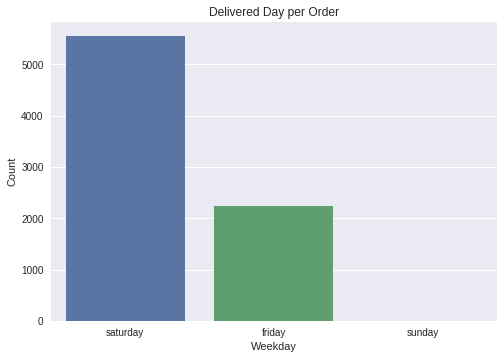

In [77]:
sns.countplot(x='weekday2', data=df_eda, order=df_eda['weekday2'].value_counts().index)
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.title("Delivered Day per Order");

Otro punto importante a mencionar, el promedio de entrega (minutos) en los días __viernes y sábado__ son de __76% y 83%__ respectivamente, en comparación, si bien existe un __8%__ de diferencia entre ellos se debe también a la diferencia de las ordenes entregadas por día, sábado tiene una cantidad de __5553__ ordenes o pedidos y viernes tiene __2248__, es decir, la differencia entre ellos es de más de __3000__ ordenes, por último, domingo tiene un alto promedio de __117%__ pero se debe a que es una sola orden que se entregó ese día.

In [78]:
df_eda.groupby('weekday2')['total_minutes'].mean()

weekday2
friday       75.638289
saturday     83.341390
sunday      117.480189
Name: total_minutes, dtype: float64

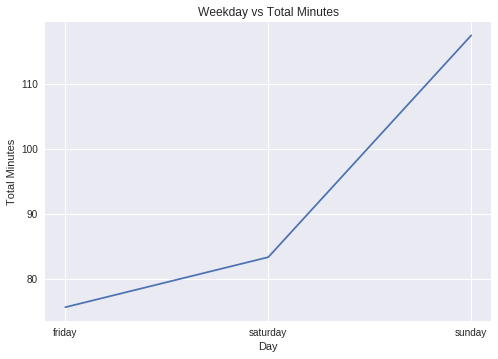

In [79]:
plt.plot(df_eda.groupby('weekday2').mean()['total_minutes'])
plt.title('Weekday vs Total Minutes')
plt.xlabel("Day")
plt.ylabel("Total Minutes");

En esta tabla se puede apreciar el promedio de entrega `total_minutes` en cada hora por el día que se hicieron los delivery, para el día viernes entre las __22 y 23 horas__ fueron donde se hicieron más entregas, también se puede observar que el rango horario de entrega es entre las __19 y 23 horas__, donde las 19 tiene el menor promedio, se puede concluir que las personas tienden a comprar generalmente después de salir del trabajo.

Para el día sábado ocurre todo lo contrario con respecto a los otros días, aquí las entregas se realizan en más horas del día, se puede notar como en el rango entre las __20 y 23 horas__ es donde existe un alto promedio con más del __90%__ a excepción de las __22 horas__ donde cae un poco, claramente, las personas tienden a realizar más pedidos en este rango de tiempo debido a que pueden estar en compañía con amigos y/o familiares, por otra parte, en el rango entre las __0 y 2 horas__ el promedio es más del __80%__, esto puede ser ya que las personas tienden a soliciar más o tienden a estar más tiempo despierto debido a que es my probable que no tengan que trabajar el sábado.

Por último, el día domingo la única entrega que se realizó fue a las __00:00 horas__, es muy probable que se pedido haya sido para las __23 horas__ del sábado y se retrasó lo que quedo como incumplimiento del tiempo estimado por parte de `Cornershop`. Otro punto a resaltar de este dataset es que el domingo no se hizo ninguna entrega en otras horas, cuando por lo general las personas tienden a no cocinar ese día y comprar a tiendas.

In [80]:
table = pd.pivot_table(df_eda, columns='weekday2', index='hour', values='total_minutes', aggfunc='mean')

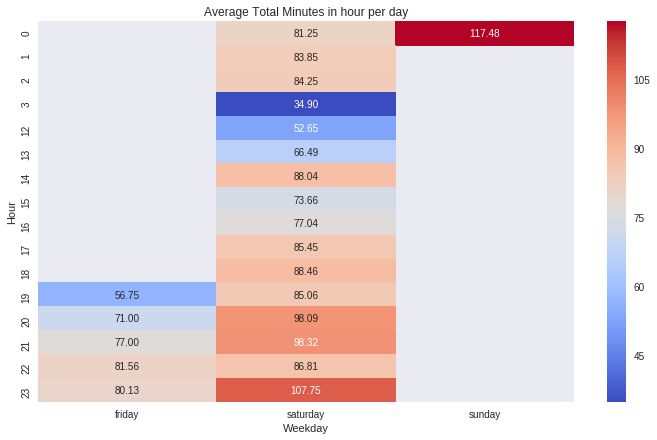

In [81]:
plt.figure(figsize=(12, 7))
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.2f')
plt.xlabel("Weekday")
plt.ylabel("Hour")
plt.title("Average Total Minutes in hour per day");

No se aprecia una alta correlación entre el vector objetivo `total_minutes` con respecto a los demás atributos, en cuanto, a los atributos independiente entre sí, se puede notar como `friday` y `saturday` presentan una alta correlación con `day` de manera negativa y positiva respectivamente, es de esperarse, ya que es la variable binarizada, antes de modelar se eliminarán atributos irrelevantes.

In [82]:
df_corr = df_eda.corr()

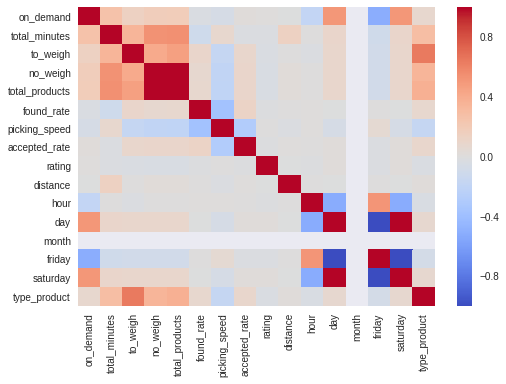

In [83]:
sns.heatmap(df_corr,  cmap='coolwarm', fmt='.2f');

Se borraron atributos que se consideran irrelevantes como `promised_time`, `day` y `weekday2`, además, se aplicó una binarización al atributo `seniority` con la técnica de __OneHotEncoding__ para evitar algún tipo de orden al modelar los datos por medio del algoritmo de Machine Learning, ya que es un atributo nominal. 

In [84]:
# Removing irrelevant columns
orders_imp = orders_imp.drop(columns=['promised_time', 'day', 'weekday2'])

orders_no_imp = orders_no_imp.drop(columns=['promised_time', 'day', 'weekday2'])

# One Hot Encoding
orders_imp = pd.get_dummies(orders_imp, columns=['seniority'], 
                            prefix='seniority', prefix_sep='_', drop_first='True')

orders_no_imp = pd.get_dummies(orders_no_imp, columns=['seniority'], 
                            prefix='seniority', prefix_sep='_', drop_first='True')

En esta ocasión antes de pasar a la etapa de modelación se terminará de ajustar el dataframe, se aplica una binarización al atributo `seniority` y se aislan los datos que no presentan `total_minutes`, es importante recordar que se aplica a los dataframes con datos imputados y sin imputar, donde para los datos imputados mantenemos un total de __9978__ observaciones, donde solo __1995__ observaciones corresponden a aquellas que no tienen un tiempo de entrega, representando el __20%__ de la data total. 

Para el dataframe que no se aplicó imputaciones, y fueron borradas las observaciones de los atributos `found_rate`, `accepted_rate` y `rating` este quedó con un total de __9762__ y con una cantidad de __1960__ como datos a predecir, representando el también el __20%__ de la data.

__Nota:__ Se hace exportación de los data test de los dataframes con y sin imputaciones.

In [85]:
# Missig Values Table, imputaded dataframe
total = orders_imp.isnull().sum().sort_values(ascending=False)
percent = (orders_imp.isnull().sum() / orders_imp.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values.head()

,Total,Percent(%)
total_minutes,1995,19.993987
seniority_REVIEW,0,0.000000
seniority_INTERMEDIATE,0,0.000000
on_demand,0,0.000000
to_weigh,0,0.000000


In [86]:
orders_imp_data_test = orders_imp[orders_imp['total_minutes'].isnull()]

In [87]:
orders_imp = orders_imp[orders_imp['total_minutes'].notnull()]

In [88]:
# Missig Values Table, no imputation
total = orders_no_imp.isnull().sum().sort_values(ascending=False)
percent = (orders_no_imp.isnull().sum() / orders_no_imp.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values.head()

,Total,Percent(%)
total_minutes,1995,19.993987
found_rate,199,1.994388
rating,162,1.623572
accepted_rate,46,0.461014
picking_speed,0,0.000000


In [89]:
orders_no_imp = orders_no_imp.dropna(subset=['found_rate', 'rating', 'accepted_rate'])

In [90]:
# Missig Values Table, no imputation
total = orders_no_imp.isnull().sum().sort_values(ascending=False)
percent = (orders_no_imp.isnull().sum() / orders_no_imp.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values.head()

,Total,Percent(%)
total_minutes,1960,20.077853
seniority_REVIEW,0,0.000000
seniority_INTERMEDIATE,0,0.000000
on_demand,0,0.000000
to_weigh,0,0.000000


In [91]:
orders_no_imp_data_test = orders_no_imp[orders_no_imp['total_minutes'].isnull()]

In [92]:
orders_no_imp = orders_no_imp[orders_no_imp['total_minutes'].notnull()]

In [93]:
# Exporting datatest
orders_imp_data_test.to_csv('data/orders_imp_data_test.csv', header=True, index=False)
orders_no_imp_data_test.to_csv('data/orders_no_imp_data_test.csv', header=True, index=False)

## 4. Predictive Models

Antes de modelar los datos estos serán estandarizados, y posteriorente se crearán los modelos predictivos, con los  siguientes algoritmos de Machine Learning:
* LinearRegression
* XGBoostRegressor
* RandomForestRegressor
* SVR
* LinearGAM

__Modelos:__ Se crearán modelos con los 2 dataframes (imputado, no imputado) creados, los modelos a crear estarán segmentados cuando el atributo `on_demand` es __True o False__ para este caso serán los valores __0 y 1__ respectivamente. También se harán ajustes de hiperparámetros para intentar buscar mejorar el performance de los modelos después de haberse hecho una implementación `vanilla` (valores por defecto), debido a que a veces los hiperparámetros que tienen por defecto los algoritmos hacen que se tengan un mejor resultado. 

Se tomará como base line el resultado de `LinearRegressor`, a partir de ahí se busca mejorar ese valor con la implementación de otros algoritmos de __ML__.

__Criterio de evaluación:__ Para esta problemática estaré tomando como criterio de evaluación `MAE` y `RMSE`, donde finalmente me fijaré en los resultados que arroje `MAE`, esto se debe a que principalmente es más robusta a datasets cuando presentan outliers que es lo que tenemos actualmente.

In [94]:
orders_imp.shape

(7983, 18)

In [95]:
orders_no_imp.shape

(7802, 18)

In [96]:
orders_imp_0 = orders_imp[orders_imp['on_demand'] == 0] # True
orders_imp_1 = orders_imp[orders_imp['on_demand'] == 1] # False

orders_no_imp_0 = orders_no_imp[orders_no_imp['on_demand'] == 0] # True
orders_no_imp_1 = orders_no_imp[orders_no_imp['on_demand'] == 1] # False

In [97]:
# Splitting data in training and test
# dataframe imputaed
X_imp_0 = orders_imp_0.drop(columns=['total_minutes', 'order_id']) # remove order_id column and target
y_imp_0 = orders_imp_0['total_minutes']

X_train_imp_0, X_test_imp_0, y_train_imp_0, y_test_imp_0 = train_test_split(X_imp_0, 
                                                                            y_imp_0, 
                                                                            test_size=.20, 
                                                                            random_state=123)

X_imp_1 = orders_imp_1.drop(columns=['total_minutes', 'order_id']) # remove order_id column 
y_imp_1 = orders_imp_1['total_minutes']

X_train_imp_1, X_test_imp_1, y_train_imp_1, y_test_imp_1 = train_test_split(X_imp_1, 
                                                                            y_imp_1, 
                                                                            test_size=.20, 
                                                                            random_state=123)

# dataframe no imputaed
X_no_imp_0 = orders_no_imp_0.drop(columns=['total_minutes', 'order_id']) # remove order_id column and target
y_no_imp_0 = orders_no_imp_0['total_minutes']

X_train_no_imp_0, X_test_no_imp_0, y_train_no_imp_0, y_test_no_imp_0 = train_test_split(X_no_imp_0,
                                                                                        y_no_imp_0,
                                                                                        test_size=.20,
                                                                                        random_state=123)

X_no_imp_1 = orders_no_imp_1.drop(columns=['total_minutes', 'order_id']) # remove order_id column and target
y_no_imp_1 = orders_no_imp_1['total_minutes']

X_train_no_imp_1, X_test_no_imp_1, y_train_no_imp_1, y_test_no_imp_1 = train_test_split(X_no_imp_1,
                                                                                        y_no_imp_1,
                                                                                        test_size=.20,
                                                                                        random_state=123)

In [98]:
# Standarization
# dataframe imputaed
scaled_imp_0 = StandardScaler().fit(X_train_imp_0)

X_train_imp_0_scaled = scaled_imp_0.transform(X_train_imp_0)
X_test_imp_0_scaled = scaled_imp_0.transform(X_test_imp_0)

scaled_imp_1 = StandardScaler().fit(X_train_imp_1)

X_train_imp_1_scaled = scaled_imp_1.transform(X_train_imp_1)
X_test_imp_1_scaled = scaled_imp_1.transform(X_test_imp_1)

# dataframe no imputaed
scaled_no_imp_0 = StandardScaler().fit(X_train_no_imp_0)
X_train_no_imp_0_scaled = scaled_no_imp_0.transform(X_train_no_imp_0)
X_test_no_imp_0_scaled = scaled_no_imp_0.transform(X_test_no_imp_0)

scaled_no_imp_1 = StandardScaler().fit(X_train_no_imp_1)
X_train_no_imp_1_scaled = scaled_no_imp_1.transform(X_train_no_imp_1)
X_test_no_imp_1_scaled = scaled_no_imp_1.transform(X_test_no_imp_1)

### Dataframe Imputaed
#### LinearRegression
#### LinearRegression (on_demand=0)

In [99]:
lr_model_imp_0 = LinearRegression(fit_intercept=True, normalize=False)
lr_model_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

# Predictions
lr_model_imp_0_pred = lr_model_imp_0.predict(X_test_imp_0_scaled)

In [100]:
mae_lr_imp_0 = mean_absolute_error(y_test_imp_0, lr_model_imp_0_pred)
rmse_lr_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, lr_model_imp_0_pred))

In [101]:
print("MAE LR IMP0: ", mae_lr_imp_0)
print("RMSE LR IMP0: ", rmse_lr_imp_0)

MAE LR IMP0:  17.94788242077604
RMSE LR IMP0:  25.059216363085245


#### LinearRegression (on_demand=1)

In [102]:
lr_model_imp_1 = LinearRegression(fit_intercept=True, normalize=False)
lr_model_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

# Predictions
lr_model_imp_1_pred = lr_model_imp_1.predict(X_test_imp_1_scaled)

In [103]:
mae_lr_imp_1 = mean_absolute_error(y_test_imp_1, lr_model_imp_1_pred)
rmse_lr_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, lr_model_imp_1_pred))

In [104]:
print("MAE LR IMP1: ", mae_lr_imp_1)
print("RMSE LR IMP1: ", rmse_lr_imp_1)

MAE LR IMP1:  21.76951898079709
RMSE LR IMP1:  27.784052728915654


#### XGBoostRegressor
#### XGBoostRegressor (on_demand=0)

In [105]:
xgb_model_imp_0 = XGBRegressor()
xgb_model_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

# Predictions
xgb_model_imp_0_pred = xgb_model_imp_0.predict(X_test_imp_0_scaled)

In [106]:
mae_xgb_imp_0 = mean_absolute_error(y_test_imp_0, xgb_model_imp_0_pred)
rmse_xgb_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, xgb_model_imp_0_pred))

In [107]:
print("MAE XGB IMP0: ", mae_xgb_imp_0)
print("RMSE XGB IMP0: ", rmse_xgb_imp_0)

MAE XGB IMP0:  17.48256971971035
RMSE XGB IMP0:  24.461746319883368


Aplico `GridSearchCV` para encontrar valores óptimos de los hiperparámetros y mejorar el performance del modelo.

In [108]:
# Grid Search
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [i/10.0 for i in range(6,11)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)
grid_search = GridSearchCV(XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_xgb = grid_search.fit(X_train_imp_0_scaled, y_train_imp_0)

print('XGB Best Score: ', result_xgb.best_score_)
print('XGB Best Params: ', result_xgb.best_params_)

XGB Best Score:  0.3022212365024277
XGB Best Params:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.6}


In [109]:
# Predictions
bst_xgb_model_imp_0_pred = result_xgb.best_estimator_.predict(X_test_imp_0_scaled)

In [110]:
bst_mae_xgb_imp_0 = mean_absolute_error(y_test_imp_0, bst_xgb_model_imp_0_pred)
bst_rmse_xgb_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, bst_xgb_model_imp_0_pred))

In [111]:
print("Best MAE XGB IMP0: ", bst_mae_xgb_imp_0)
print("Best RMSE XGB IMP0: ", bst_rmse_xgb_imp_0)

Best MAE XGB IMP0:  17.22650098575476
Best RMSE XGB IMP0:  24.207890444768566


#### XGBoostRegressor (on_demand=1)

In [112]:
xgb_model_imp_1 = XGBRegressor()
xgb_model_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

# Predictions
xgb_model_imp_1_pred = xgb_model_imp_1.predict(X_test_imp_1_scaled)

In [113]:
mae_xgb_imp_1 = mean_absolute_error(y_test_imp_1, xgb_model_imp_1_pred)
rmse_xgb_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, xgb_model_imp_1_pred))

In [114]:
print("MAE XGB IMP1: ", mae_xgb_imp_1)
print("RMSE XGB IMP1: ", rmse_xgb_imp_1)

MAE XGB IMP1:  20.143996177185144
RMSE XGB IMP1:  25.984217520830484


Aplico `GridSearchCV` para encontrar valores óptimos de los hiperparámetros y mejorar el performance del modelo.

In [115]:
# Grid Search
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [i/10.0 for i in range(6,11)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)
grid_search = GridSearchCV(XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_xgb2 = grid_search.fit(X_train_imp_1_scaled, y_train_imp_1)

print('XGB Best Score: ', result_xgb2.best_score_)
print('XGB Best Params: ', result_xgb2.best_params_)

XGB Best Score:  0.47488502010503064
XGB Best Params:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.6}


In [116]:
# Predictions
bst_xgb_model_imp_1_pred = result_xgb2.best_estimator_.predict(X_test_imp_1_scaled)

In [117]:
bst_mae_xgb_imp_1 = mean_absolute_error(y_test_imp_1, bst_xgb_model_imp_1_pred)
bst_rmse_xgb_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, bst_xgb_model_imp_1_pred))

In [118]:
print("Best MAE XGB IMP1: ", bst_mae_xgb_imp_1)
print("Best RMSE XGB IMP1: ", bst_rmse_xgb_imp_1)

Best MAE XGB IMP1:  20.273258173589753
Best RMSE XGB IMP1:  26.133764537272683


#### RandomForest
#### RandomForest (on_demand=0)

In [119]:
rf_model_imp_0 = RandomForestRegressor()
rf_model_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

rf_model_imp_0_pred = rf_model_imp_0.predict(X_test_imp_0_scaled)

In [120]:
mae_rf_imp_0 = mean_absolute_error(y_test_imp_0, rf_model_imp_0_pred)
rmse_rf_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, rf_model_imp_0_pred))

In [121]:
print("MAE RF IMP0: ", mae_rf_imp_0)
print("RMSE RF IMP0: ", rmse_rf_imp_0)

MAE RF IMP0:  17.352098914318162
RMSE RF IMP0:  24.448494892147274


Ajustando Hiperparametros

In [122]:
#Listas para guardar los valores temporales
tmp_oob_none, tmp_oob_sqrt, tmp_oob_log2 = [], [], []
n_estimators = range(5, 1000, 20)

In [123]:
#Evaluación de los n_estimators
for i in n_estimators:
    #Implementamos una variante con todos los atributos
    rf_none = RandomForestRegressor(n_estimators=i, max_features=None,
                                     oob_score=True,
                                     random_state=123).fit(X_train_imp_0_scaled, y_train_imp_0)
    
    #Implementamos una variante donde los atributos se escogen con sqrt
    rf_sqrt = RandomForestRegressor(n_estimators=i, max_features='sqrt',
                                     warm_start=True,
                                     oob_score=True,
                                     random_state=123).fit(X_train_imp_0_scaled, y_train_imp_0)
    
    #Implementamos una variante donde los atributos se escogen con log2
    rf_log = RandomForestRegressor(n_estimators=i, max_features='log2',
                                    warm_start=True,
                                    oob_score=True,
                                   random_state=123).fit(X_train_imp_0_scaled, y_train_imp_0)
    
    tmp_oob_none.append(1 - rf_none.oob_score)
    tmp_oob_sqrt.append(1 - rf_sqrt.oob_score)
    tmp_oob_log2.append(1 - rf_log.oob_score)

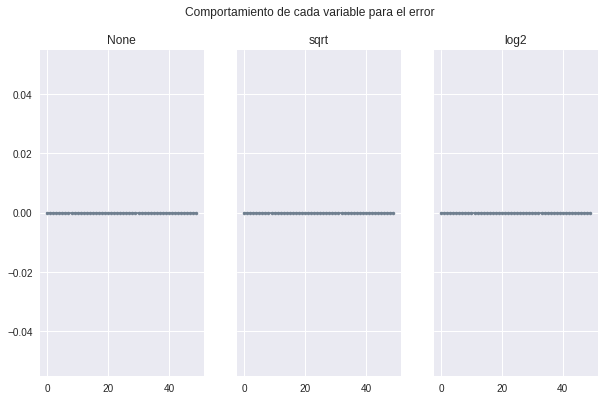

In [124]:
#Graficamos el comportamiento de cada variable
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

ax1 = axs[0]
ax1.plot(tmp_oob_none, '.-', color='slategrey', label='OOB None')
ax1.set_title("None")

ax2 = axs[1]
ax2.plot(tmp_oob_sqrt, ".-", color='slategrey', label='OOB sqrt')
ax2.set_title("sqrt")

ax3 = axs[2]
ax3.plot(tmp_oob_log2, ".-", color='slategrey', label="OOB log2")
ax3.set_title("log2")

fig.suptitle("Comportamiento de cada variable para el error");

In [125]:
rf_model2_imp_0 = RandomForestRegressor(max_features='log2',n_estimators=5, n_jobs=-1, random_state=5, verbose=False)
rf_model2_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

# Predictions
rf_model2_imp_0_pred = rf_model2_imp_0.predict(X_test_imp_0_scaled)

In [126]:
mae_rf2_imp_0 = mean_absolute_error(y_test_imp_0, rf_model2_imp_0_pred)
rmse_rf2_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, rf_model2_imp_0_pred))

In [127]:
print("MAE RF2 IMP0: ", mae_rf2_imp_0)
print("RMSE RF2 IMP0: ", rmse_rf2_imp_0)

MAE RF2 IMP0:  19.866935090013765
RMSE RF2 IMP0:  26.98612620218555


#### RandomForest (on_demand=1)

In [128]:
rf_model_imp_1 = RandomForestRegressor()
rf_model_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

# Predictions
rf_model_imp_1_pred = rf_model_imp_1.predict(X_test_imp_1_scaled)

In [129]:
mae_rf_imp_1 = mean_absolute_error(y_test_imp_1, rf_model_imp_1_pred)
rmse_rf_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, rf_model_imp_1_pred))

In [130]:
print("MAE RF IMP1: ", mae_rf_imp_1)
print("RMSE RF IMP1: ", rmse_rf_imp_1)

MAE RF IMP1:  21.119577763759175
RMSE RF IMP1:  26.835458278634537


Ajustando Hiperparametros

In [131]:
rf_model2_imp_1 = RandomForestRegressor(max_features='log2',n_estimators=5, n_jobs=-1, random_state=5, verbose=False)
rf_model2_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

rf_model2_imp_1_pred = rf_model2_imp_1.predict(X_test_imp_1_scaled)

In [132]:
mae_rf2_imp_1 = mean_absolute_error(y_test_imp_1, rf_model2_imp_1_pred)
rmse_rf2_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, rf_model2_imp_1_pred))

In [133]:
print("MAE RF2 IMP1: ", mae_rf2_imp_1)
print("RMSE RF2 IMP1: ", rmse_rf2_imp_1)

MAE RF2 IMP1:  22.643938284270956
RMSE RF2 IMP1:  29.209518992735596


#### SVR
#### SVR (on_demand=0)

In [134]:
svr_model_imp_0 = SVR()
svr_model_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

# Predictions
svr_model_imp_0_pred = svr_model_imp_0.predict(X_test_imp_0_scaled)

In [135]:
mae_svr_imp_0 = mean_absolute_error(y_test_imp_0, svr_model_imp_0_pred)
rmse_svr_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, svr_model_imp_0_pred))

In [136]:
print("MAE SVR IMP0: ", mae_svr_imp_0)
print("RMSE SVR IMP0: ", rmse_svr_imp_0)

MAE SVR IMP0:  17.98283179808305
RMSE SVR IMP0:  26.367266325276077


Ajustando Hiperparámetros

In [137]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=C, gamma=gamma)
grid_search_svr = GridSearchCV(SVR(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_svr = grid_search_svr.fit(X_train_imp_0_scaled, y_train_imp_0)

print('SVR Best Score: ', result_svr.best_score_)
print('SVR Best Params: ', result_svr.best_params_)

SVR Best Score:  0.26630186423959923
SVR Best Params:  {'C': 100, 'gamma': 0.01}


In [138]:
# Predictions
bst_svr_model_imp_0_pred = result_svr.best_estimator_.predict(X_test_imp_0_scaled)

In [139]:
bst_mae_svr_imp_0 = mean_absolute_error(y_test_imp_0, bst_svr_model_imp_0_pred)
bst_rmse_svr_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, bst_svr_model_imp_0_pred))

In [140]:
print("BEST MAE SVR IMP0: ", bst_mae_svr_imp_0)
print("BEST RMSE SVR IMP0: ", bst_rmse_svr_imp_0)

BEST MAE SVR IMP0:  16.79983061767892
BEST RMSE SVR IMP0:  25.162645351538018


#### SVR (on_demand=1)

In [141]:
svr_model_imp_1 = SVR()
svr_model_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

# Predictions
svr_model_imp_1_pred = svr_model_imp_1.predict(X_test_imp_1_scaled)

In [142]:
mae_svr_imp_1 = mean_absolute_error(y_test_imp_1, svr_model_imp_1_pred)
rmse_svr_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, svr_model_imp_1_pred))

In [143]:
print("MAE SVR IMP1: ", mae_svr_imp_1)
print("RMSE SVR IMP1: ", rmse_svr_imp_1)

MAE SVR IMP1:  21.710517002863813
RMSE SVR IMP1:  28.872473551119278


Ajusto Hiperparámetros

In [144]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=C, gamma=gamma)
grid_search_svr2 = GridSearchCV(SVR(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_svr2 = grid_search_svr2.fit(X_train_imp_1_scaled, y_train_imp_1)

print('SVR Best Score: ', result_svr2.best_score_)
print('SVR Best Params: ', result_svr2.best_params_)

SVR Best Score:  0.43200593672235127
SVR Best Params:  {'C': 1000, 'gamma': 0.01}


In [145]:
# Predictions
bst_svr_model_imp_1_pred = result_svr2.best_estimator_.predict(X_test_imp_1_scaled)

In [146]:
bst_mae_svr_imp_1 = mean_absolute_error(y_test_imp_1, bst_svr_model_imp_1_pred)
bst_rmse_svr_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, bst_svr_model_imp_1_pred))

In [147]:
print("BEST MAE SVR IMP1: ", bst_mae_svr_imp_1)
print("BEST RMSE SVR IMP1: ", bst_rmse_svr_imp_1)

BEST MAE SVR IMP1:  20.69473319035351
BEST RMSE SVR IMP1:  27.44632179338217


#### LinearGAM
#### LinearGAM (on_demand=0)

In [148]:
lgam_model_imp_0 = LinearGAM()
lgam_model_imp_0.fit(X_train_imp_0_scaled, y_train_imp_0)

# Predictions
lgam_model_imp_0_pred = lgam_model_imp_0.predict(X_test_imp_0_scaled)

In [149]:
mae_lgam_imp_0 = mean_absolute_error(y_test_imp_0, lgam_model_imp_0_pred)
rmse_lgam_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, lgam_model_imp_0_pred))

In [150]:
print("MAE LGAM IMP0: ", mae_lgam_imp_0)
print("RMSE LGAM IMP0: ", rmse_lgam_imp_0)

MAE LGAM IMP0:  17.945388714266482
RMSE LGAM IMP0:  26.37758312331905


Ajusto hiperparàmetros

In [151]:
# Rango del hiperparametro
param_grids = {'lam': np.logspace(-3, 3, 11)}

lgam_model2_imp_0 = LinearGAM().gridsearch(X_train_imp_0_scaled, y_train_imp_0, **param_grids)

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


In [152]:
# Predictions
lgam_model2_imp_0_pred = lgam_model2_imp_0.predict(X_test_imp_0_scaled)

In [153]:
mae_lgam2_imp_0 = mean_absolute_error(y_test_imp_0, lgam_model2_imp_0_pred)
rmse_lgam2_imp_0 = np.sqrt(mean_squared_error(y_test_imp_0, lgam_model2_imp_0_pred))

In [154]:
print("MAE LGAM2 IMP0: ", mae_lgam2_imp_0)
print("RMSE LGAM2 IMP0: ", rmse_lgam2_imp_0)

MAE LGAM2 IMP0:  17.579219206951784
RMSE LGAM2 IMP0:  24.528165201885162


#### LinearGAM (on_demand=1)

In [155]:
lgam_model_imp_1 = LinearGAM()
lgam_model_imp_1.fit(X_train_imp_1_scaled, y_train_imp_1)

# Predictions
lgam_model_imp_1_pred = lgam_model_imp_1.predict(X_test_imp_1_scaled)

In [156]:
mae_lgam_imp_1 = mean_absolute_error(y_test_imp_1, lgam_model_imp_1_pred)
rmse_lgam_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, lgam_model_imp_1_pred))

In [157]:
print("MAE LGAM IMP1: ", mae_lgam_imp_1)
print("RMSE LGAM IMP1: ", rmse_lgam_imp_1)

MAE LGAM IMP1:  20.54134619071606
RMSE LGAM IMP1:  26.388077720670445


Ajusto Hiperparámetros

In [158]:
# Rango del hiperparametro
param_grids = {'lam': np.logspace(-3, 3, 11)}

lgam_model2_imp_1 = LinearGAM().gridsearch(X_train_imp_1_scaled, y_train_imp_1, **param_grids)

100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


In [159]:
# Predictions
lgam_model2_imp_1_pred = lgam_model2_imp_1.predict(X_test_imp_1_scaled)

In [160]:
mae_lgam2_imp_1 = mean_absolute_error(y_test_imp_1, lgam_model2_imp_1_pred)
rmse_lgam2_imp_1 = np.sqrt(mean_squared_error(y_test_imp_1, lgam_model2_imp_1_pred))

In [161]:
print("MAE LGAM2 IMP1: ", mae_lgam2_imp_1)
print("RMSE LGAM2 IMP1: ", rmse_lgam2_imp_1)

MAE LGAM2 IMP1:  20.58597947524234
RMSE LGAM2 IMP1:  26.42804565553862


### Dataframe No Imputaed
#### LinearRegression
#### LinearRegression (on_demand=0)

In [162]:
lr_model_no_imp_0 = LinearRegression(fit_intercept=True, normalize=False)
lr_model_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

# Predictions
lr_model_no_imp_0_pred = lr_model_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_lr_no_imp_0 = mean_absolute_error(y_test_no_imp_0, lr_model_no_imp_0_pred)
rmse_lr_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, lr_model_no_imp_0_pred))  

print("MAE LR NO IMP0: ", mae_lr_no_imp_0)
print("RMSE LR NO IMP0: ", rmse_lr_no_imp_0)

MAE LR NO IMP0:  18.385414279081303
RMSE LR NO IMP0:  25.85150884587999


#### LinearRegression (on_demand=1)

In [163]:
lr_model_no_imp_1 = LinearRegression(fit_intercept=True, normalize=False)
lr_model_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

# Predictions
lr_model_no_imp_1_pred = lr_model_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_lr_no_imp_1 = mean_absolute_error(y_test_no_imp_1, lr_model_no_imp_1_pred)
rmse_lr_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, lr_model_no_imp_1_pred))

print("MAE LR NO IMP1: ", mae_lr_no_imp_1)
print("RMSE LR NO IMP1: ", rmse_lr_no_imp_1)

MAE LR NO IMP1:  21.316139615620806
RMSE LR NO IMP1:  27.255742847107115


#### XGBoostRegressor
#### XGBoostRegressor (on_demand=0)

In [164]:
xgb_model_no_imp_0 = XGBRegressor()
xgb_model_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

# Predictions
xgb_model_no_imp_0_pred = xgb_model_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_xgb_no_imp_0 = mean_absolute_error(y_test_no_imp_0, xgb_model_no_imp_0_pred)
rmse_xgb_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, xgb_model_no_imp_0_pred))

print("MAE XGB NO IMP0: ", mae_xgb_no_imp_0)
print("RMSE XGB NO IMP0: ", rmse_xgb_no_imp_0)

MAE XGB NO IMP0:  17.758915098119754
RMSE XGB NO IMP0:  24.885509642289282


Ajusto hiperparámetros

In [165]:
# Grid Search
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [i/10.0 for i in range(6,11)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)
grid_search_no_imp0 = GridSearchCV(XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_xgb_no_imp_0 = grid_search_no_imp0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

print('XGB Best Score: ', result_xgb_no_imp_0.best_score_)
print('XGB Best Params: ', result_xgb_no_imp_0.best_params_)

XGB Best Score:  0.3095910226487594
XGB Best Params:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.6}


In [166]:
# Predictions
bst_xgb_model_no_imp_0_pred = result_xgb_no_imp_0.best_estimator_.predict(X_test_no_imp_0_scaled)

bst_mae_xgb_no_imp_0 = mean_absolute_error(y_test_no_imp_0, bst_xgb_model_no_imp_0_pred)
bst_rmse_xgb_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, bst_xgb_model_no_imp_0_pred))

print("BEST MAE XGB NO IMP0: ", bst_mae_xgb_no_imp_0)
print("BEST RMSE XGB NO IMP0: ", bst_rmse_xgb_no_imp_0)

BEST MAE XGB NO IMP0:  17.649199301729947
BEST RMSE XGB NO IMP0:  24.738424431877934


#### XGBoostRegressor (on_demand=1)

In [167]:
xgb_model_no_imp_1 = XGBRegressor()
xgb_model_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

# Predictions
xgb_model_no_imp_1_pred = xgb_model_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_xgb_no_imp_1 = mean_absolute_error(y_test_no_imp_1, xgb_model_no_imp_1_pred)
rmse_xgb_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, xgb_model_no_imp_1_pred))

print("MAE XGB NO IMP1: ", mae_xgb_no_imp_1)
print("RMSE XGB NO IMP1: ", rmse_xgb_no_imp_1)

MAE XGB NO IMP1:  19.645469775996908
RMSE XGB NO IMP1:  25.089478725513768


Ajusto Hiperparámetros

In [168]:
# Grid Search
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [i/10.0 for i in range(6,11)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)
grid_search_no_imp1 = GridSearchCV(XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_xgb_no_imp_1 = grid_search_no_imp1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

print('XGB Best Score: ', result_xgb_no_imp_1.best_score_)
print('XGB Best Params: ', result_xgb_no_imp_1.best_params_)

XGB Best Score:  0.47452238478580255
XGB Best Params:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.6}


In [169]:
# Predictions
bst_xgb_model_imp_1_pred = result_xgb_no_imp_1.best_estimator_.predict(X_test_no_imp_1_scaled)

bst_mae_xgb_no_imp_1 = mean_absolute_error(y_test_no_imp_1, bst_xgb_model_imp_1_pred)
bst_rmse_xgb_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, bst_xgb_model_imp_1_pred))

print("Best MAE XGB NO IMP1: ", bst_mae_xgb_no_imp_1)
print("Best RMSE XGB NO IMP1: ", bst_rmse_xgb_no_imp_1)

Best MAE XGB NO IMP1:  19.512933503698694
Best RMSE XGB NO IMP1:  25.044401706308616


#### RandomForest
#### RandomForest (on_demand=0)

In [170]:
rf_model_no_imp_0 = RandomForestRegressor()
rf_model_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

rf_model_no_imp_0_pred = rf_model_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_rf_no_imp_0 = mean_absolute_error(y_test_no_imp_0, rf_model_no_imp_0_pred)
rmse_rf_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, rf_model_no_imp_0_pred))

print("MAE RF NO IMP0: ", mae_rf_no_imp_0)
print("RMSE RF NO IMP0: ", rmse_rf_no_imp_0)

MAE RF NO IMP0:  18.560706477847344
RMSE RF NO IMP0:  25.43725638270399


Ajusto Hiperparámetros

In [171]:
rf_model2_no_imp_0 = RandomForestRegressor(max_features='log2',n_estimators=5, n_jobs=-1, random_state=5, verbose=False)
rf_model2_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

rf_model2_no_imp_0_pred = rf_model2_no_imp_0.predict(X_test_no_imp_0_scaled)
mae_rf2_no_imp_0 = mean_absolute_error(y_test_no_imp_0, rf_model2_no_imp_0_pred)
rmse_rf2_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, rf_model2_no_imp_0_pred))

print("MAE RF2 NO IMP0: ", mae_rf2_no_imp_0)
print("RMSE RF2 NO IMP0: ", rmse_rf2_no_imp_0)

MAE RF2 NO IMP0:  20.217026421683208
RMSE RF2 NO IMP0:  27.660101406843385


#### RandomForest (on_demand=1)

In [172]:
rf_model_no_imp_1 = RandomForestRegressor()
rf_model_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

# Predictions
rf_model_no_imp_1_pred = rf_model_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_rf_no_imp_1 = mean_absolute_error(y_test_no_imp_1, rf_model_no_imp_1_pred)
rmse_rf_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, rf_model_no_imp_1_pred))

print("MAE RF NO IMP1: ", mae_rf_no_imp_1)
print("RMSE RF NO IMP1: ", rmse_rf_no_imp_1)

MAE RF NO IMP1:  20.439023537116576
RMSE RF NO IMP1:  25.904194488791944


Ajusto Hiperparámetros

In [173]:
rf_model2_no_imp_1 = RandomForestRegressor(max_features='log2',n_estimators=5, n_jobs=-1, random_state=5, verbose=False)
rf_model2_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

rf_model2_no_imp_1_pred = rf_model2_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_rf2_no_imp_1 = mean_absolute_error(y_test_no_imp_1, rf_model2_no_imp_1_pred)
rmse_rf2_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, rf_model2_no_imp_1_pred))

print("MAE RF2 NO IMP1: ", mae_rf2_no_imp_1)
print("RMSE RF2 NO IMP1: ", rmse_rf2_no_imp_1)

MAE RF2 NO IMP1:  22.516885368700887
RMSE RF2 NO IMP1:  28.78708185728768


#### SVR
#### SVR (on_demand=0)

In [174]:
svr_model_no_imp_0 = SVR()
svr_model_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

# Predictions
svr_model_no_imp_0_pred = svr_model_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_svr_no_imp_0 = mean_absolute_error(y_test_no_imp_0, svr_model_no_imp_0_pred)
rmse_svr_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, svr_model_no_imp_0_pred))

print("MAE SVR NO IMP0: ", mae_svr_no_imp_0)
print("RMSE SVR NO IMP0: ", rmse_svr_no_imp_0)

MAE SVR NO IMP0:  18.476299852535995
RMSE SVR NO IMP0:  26.950034049478074


Ajusto Hiperparámetros

In [175]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=C, gamma=gamma)
grid_search_svr_no_imp0 = GridSearchCV(SVR(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_svr_no_imp_0 = grid_search_svr_no_imp0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

print('SVR Best Score: ', result_svr_no_imp_0.best_score_)
print('SVR Best Params: ', result_svr_no_imp_0.best_params_)

SVR Best Score:  0.27346418825605384
SVR Best Params:  {'C': 100, 'gamma': 0.01}


In [176]:
# Predictions
bst_svr_model_no_imp_0_pred = result_svr_no_imp_0.best_estimator_.predict(X_test_no_imp_0_scaled)

bst_mae_svr_no_imp_0 = mean_absolute_error(y_test_no_imp_0, bst_svr_model_no_imp_0_pred)
bst_rmse_svr_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, bst_svr_model_no_imp_0_pred))

print("BEST MAE SVR NO IMP0: ", bst_mae_svr_no_imp_0)
print("BEST RMSE SVR NO IMP0: ", bst_rmse_svr_no_imp_0)

BEST MAE SVR NO IMP0:  17.75310701620005
BEST RMSE SVR NO IMP0:  25.955109597592685


#### SVR (on_demand=1)

In [177]:
svr_model_no_imp_1 = SVR()
svr_model_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

# Predictions
svr_model_no_imp_1_pred = svr_model_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_svr_no_imp_1 = mean_absolute_error(y_test_no_imp_1, svr_model_no_imp_1_pred)
rmse_svr_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, svr_model_no_imp_1_pred))

print("MAE SVR NO IMP1: ", mae_svr_no_imp_1)
print("RMSE SVR NO IMP1: ", rmse_svr_no_imp_1)

MAE SVR NO IMP1:  21.534144286482352
RMSE SVR NO IMP1:  28.199979332818472


Ajusto Hiperparaámetros

In [178]:
# Hiper
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=C, gamma=gamma)
grid_search_svr_no_imp1 = GridSearchCV(SVR(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_svr_no_imp1 = grid_search_svr_no_imp1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

print('SVR Best Score: ', result_svr_no_imp1.best_score_)
print('SVR Best Params: ', result_svr_no_imp1.best_params_)


SVR Best Score:  0.4223947586447192
SVR Best Params:  {'C': 100, 'gamma': 0.01}


In [179]:
# Predictions
bst_svr_model_no_imp_1_pred = result_svr_no_imp1.best_estimator_.predict(X_test_no_imp_1_scaled)

bst_mae_svr_no_imp_1 = mean_absolute_error(y_test_no_imp_1, bst_svr_model_no_imp_1_pred)
bst_rmse_svr_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, bst_svr_model_no_imp_1_pred))

print("BEST MAE SVR NO IMP1: ", bst_mae_svr_no_imp_1)
print("BEST RMSE SVR NO IMP1: ", bst_rmse_svr_no_imp_1)

BEST MAE SVR NO IMP1:  20.05805381105003
BEST RMSE SVR NO IMP1:  26.25603049699747


#### LinearGAM
#### LinearGAM (on_demand=0)

In [180]:
lgam_model_no_imp_0 = LinearGAM()
lgam_model_no_imp_0.fit(X_train_no_imp_0_scaled, y_train_no_imp_0)

# Predictions
lgam_model_no_imp_0_pred = lgam_model_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_lgam_no_imp_0 = mean_absolute_error(y_test_no_imp_0, lgam_model_no_imp_0_pred)
rmse_lgam_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, lgam_model_no_imp_0_pred))

print("MAE LGAM NO IMP0: ", mae_lgam_no_imp_0)
print("RMSE LGAM NO IMP0: ", rmse_lgam_no_imp_0)

MAE LGAM NO IMP0:  18.259205226849147
RMSE LGAM NO IMP0:  26.028063217058893


In [181]:
# Rango del hiperparametro
param_grids = {'lam': np.logspace(-3, 3, 11)}

lgam_model2_no_imp_0 = LinearGAM().gridsearch(X_train_no_imp_0_scaled, y_train_no_imp_0, **param_grids)

# Predictions
lgam_model2_no_imp_0_pred = lgam_model2_no_imp_0.predict(X_test_no_imp_0_scaled)

mae_lgam2_no_imp_0 = mean_absolute_error(y_test_no_imp_0, lgam_model2_no_imp_0_pred)
rmse_lgam2_no_imp_0 = np.sqrt(mean_squared_error(y_test_no_imp_0, lgam_model2_no_imp_0_pred))

print("MAE LGAM2 NO IMP0: ", mae_lgam2_no_imp_0)
print("RMSE LGAM2 NO IMP0: ", rmse_lgam2_no_imp_0)

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


MAE LGAM2 NO IMP0:  18.079218025655262
RMSE LGAM2 NO IMP0:  25.366362288973527


#### LinearGAM (on_demand=1)

In [182]:
lgam_model_no_imp_1 = LinearGAM()
lgam_model_no_imp_1.fit(X_train_no_imp_1_scaled, y_train_no_imp_1)

# Predictions
lgam_model_no_imp_1_pred = lgam_model_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_lgam_no_imp_1 = mean_absolute_error(y_test_no_imp_1, lgam_model_no_imp_1_pred)
rmse_lgam_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, lgam_model_no_imp_1_pred))

print("MAE LGAM NO IMP1: ", mae_lgam_no_imp_1)
print("RMSE LGAM NO IMP1: ", rmse_lgam_no_imp_1)

MAE LGAM NO IMP1:  19.70993737124305
RMSE LGAM NO IMP1:  25.3813661243385


In [183]:
# Rango del hiperparametro
param_grids = {'lam': np.logspace(-3, 3, 11)}

lgam_model2_no_imp_1 = LinearGAM().gridsearch(X_train_no_imp_1_scaled, y_train_no_imp_1, **param_grids)

# Predictions
lgam_model2_no_imp_1_pred = lgam_model2_no_imp_1.predict(X_test_no_imp_1_scaled)

mae_lgam2_no_imp_1 = mean_absolute_error(y_test_no_imp_1, lgam_model2_no_imp_1_pred)
rmse_lgam2_no_imp_1 = np.sqrt(mean_squared_error(y_test_no_imp_1, lgam_model2_no_imp_1_pred))

print("MAE LGAM2 NO IMP1: ", mae_lgam2_no_imp_1)
print("RMSE LGAM2 NO IMP1: ", rmse_lgam2_no_imp_1)

100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


MAE LGAM2 NO IMP1:  19.700224323063008
RMSE LGAM2 NO IMP1:  25.297353543609418


In [184]:
# Best Results of MAE
metrics_imp = np.array([[mae_lr_imp_0, mae_lr_no_imp_0], 
                        [bst_mae_xgb_imp_0, bst_mae_xgb_no_imp_0], 
                        [mae_rf_imp_0, mae_rf_no_imp_0], 
                        [bst_mae_svr_imp_0, bst_mae_svr_no_imp_0],
                        [mae_lgam2_imp_0, mae_lgam2_no_imp_0]])

# Generamos una lista con los nombres de los modelos
models_imp = ['LinearR', 'XGBoostR', 'RandomForestR', 'SVR', 'LinearGAM']



metrics_no_imp = np.array([[mae_lr_imp_1, mae_lr_no_imp_1], 
                           [mae_xgb_imp_1, bst_mae_xgb_no_imp_1], 
                           [mae_rf_imp_1, mae_rf_no_imp_1], 
                           [bst_mae_svr_imp_1, bst_mae_svr_no_imp_1],
                           [mae_lgam_imp_1, mae_lgam2_no_imp_1]])

# Generamos una lista con los nombres de los modelos
models_no_imp = ['LinearR', 'XGBoostR', 'RandomForestR', 'SVR', 'LinearGAM']

Graficamos los resultados obtenidos de los diferentes modelos implementados, estos resultados se expresan de acuerdo al tiempo estimado por parte de `Cornershop` y si realmente lo cumplió, es decir, cuando el atributo `on_demand` es __0__ cumplió con lo estimado de lo contrario fue un incumplimiento.

Se aprecia cuando `on_demand` es igual a cero, el que mejor resultado tiene en los imputados es SVR con un error de __16.79__ y en no imputados es XGBoostR con un __17.64__, para cuando `on_demand` es igual a uno el que presenta mejor resultado en cuanto al error en imputados es XGBoostR con __20.14__ y para no imputados también XGBoostR con un __19.51__.

Finalmente el algoritmo a implementar de acuerdo al atributo `on_demand` cuando es cero será el de XGBoost y cuando es uno también con XGBoost y esto se aplicará solo a los dataframes __no imputados__. Ahora, ¿por qué XGBoost en no imputados cuando es cero si SVM tiene un error menor? Mi conclusión es, que si bien SVR presenta un menor valor en la función de error MAE, este contempla datos que fueron manipulados y en alguna parte del modelamiento se ajustaron mejor a los de XGBoost, teniendo un resultado un poco mejor equivalente a un __5%__, si bien, puedo implementar este algoritmo prefiero ocupar el de XGBoost donde contemplan datos que no han sido manipulados y que las observaciones que fueron eliminadas en un principio de este dataframe no repercutó en el porcentaje de datos a predecir, manteniendo un __20%__ y que la diferencia con el dataframe de imputados donde no se eliminaron observaciones es de un __2%__, la diferencia entre ellos no es tanta, lo que significa que eventualmente obteniendo más información podría mejorar mucho más el performance de XGBoost sin necesidad de manipular datos, cabe destacar, que esto sería una hipótesis a corroborar en el tiempo, de lo contrario indagaría más por qué existe un mejor desempeño con SVR.

__Nota:__ Los valores en cuanto al error están representados en la misma unidad del vector objetivo a predecir, es decir, en minutos, por ejemplo, para el caso cuando `on_demand` es cero, la predicción tendrá un error hacia arriba o abajo de acuerdo al valor predicho, que para este caso sería de __~18min__ y para uno de __~20min__.

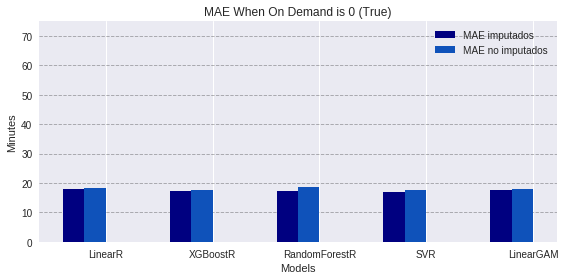

In [185]:
plot_metrics(metrics_imp, models_imp, "MAE When On Demand is 0 (True)")

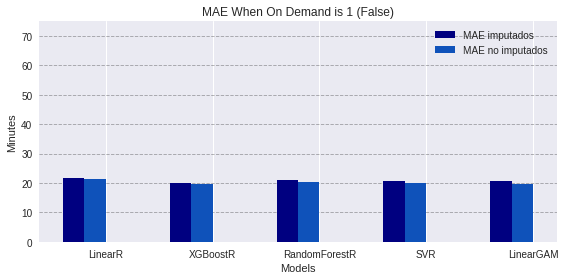

In [186]:
plot_metrics(metrics_no_imp, models_no_imp, "MAE When On Demand is 1 (False)")

Finalmente, se muestran 2 gráficos más, donde se aprecia la importancia de los atributos (feature importance) para el modelo. Para el caso que `on_demand` es cero (True), se observa que XGBoost tomó dentro de los 5 primeros a los atributos: `picking_speed`, `distance`, `found_rate`, `rating` y `total_products`, para el caso cuando `on_demand` es uno (False), los primeros 5 atributos más relavente para el modelo son: `found_rate`, `distance`, `picking_speed`, `no_weigh` y `hour`. Eventualmente, se puede hacer un análisis más exhaustivo sobre algunos de estos atributos, sobre todo en los que tienen una correlación más positiva como son `distance` y `total_products`.

On Demand is Zero (True)


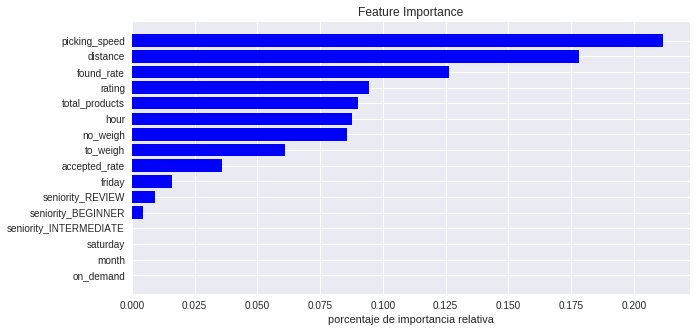

In [189]:
print("On Demand is Zero (True)")
plot_feature_importance(result_xgb_no_imp_0.best_estimator_, X_no_imp_0.columns)

On Demand is One (False)


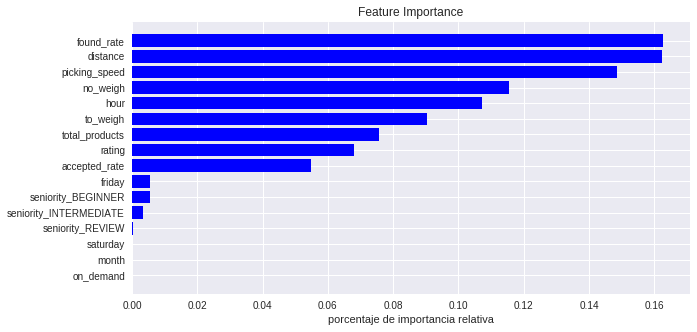

In [190]:
print("On Demand is One (False)")
plot_feature_importance(result_xgb_no_imp_1.best_estimator_, X_no_imp_0.columns)

## 5. Predictions (Results)

En esta última etapa de la prueba se realizan las predicciones en el dataset de los datos no imputados, llamado `orders_no_imp_data_test`, se separa la data en cuanto al atributo `on_demand` (0, 1), luego, se estandariza la data con el `scaled` creado para el entrenamiento y validación, se cargan los modelos antes mencionados para su eventual `predict` sobre los dataframes, se hace una copia de cada dataframe con respecto a `on_demand` para mantener el atributo `order_id` y así asociar la predicción por orden de compra, finalmente se exportan los resultados en un archivo `csv` el cual contiene las predicciones en la columna `total_minutes_pred` y una última columna donde simplemente se redonde el valor de la predicción llamada `total_minutes_rounded`. 

__Nota:__ Las predicciones están comprendidas en 2 archivos, debido a que realicé las predicciones de acuerdo al atributo `on_demand` con relación al `total_minutes`, estos archivos tienen los sguientes nombres, para los pedidos que tienen el atributo `on_demand` igual a cero (True) este es llamado `predictions_orders_on_demand_0.csv` para los que tienen `on_demand` igual a cero (False) se llama `predictions_orders_on_demand_1.csv`, estos los pondrán encontrar en la carpeta llamada `data`.

### On Demand is 0 (True)

In [191]:
# Best Models from XGBoost
model_xgb_0 = result_xgb_no_imp_0.best_estimator_
model_xgb_1 = result_xgb_no_imp_1.best_estimator_

In [192]:
# Loading dataset no imputaded
orders_datatest = pd.read_csv('data/orders_no_imp_data_test.csv') 

In [193]:
# Splitting data to predict
orders_0 = orders_datatest[orders_datatest['on_demand'] == 0]
orders_1 = orders_datatest[orders_datatest['on_demand'] == 1]

In [194]:
orders_on_demand_0 = orders_0.copy()
orders_on_demand_0.drop(columns=['total_minutes'], inplace=True)

In [195]:
orders_0_copy = orders_0.copy()
orders_0_copy = orders_0_copy.drop(columns=['total_minutes', 'order_id'])

In [196]:
# Standarization
orders_0_scaled = scaled_no_imp_0.transform(orders_0_copy)

In [197]:
# Predictions
pred_0 = model_xgb_0.predict(orders_0_scaled)

# Adding prediction column, called "total_minutes_pred"
orders_on_demand_0['total_minutes_pred'] = pred_0

In [198]:
orders_on_demand_0['total_minutes_rounded'] = orders_on_demand_0['total_minutes_pred'].apply(lambda x: round(x))

In [199]:
orders_on_demand_0.head()

,order_id,on_demand,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,hour,month,friday,saturday,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,total_minutes_pred,total_minutes_rounded
0,f629881954df817b768c981ad52c56ce,0,3,65.0,68.0,0.8671,2.50,1.000000,5.00,0.915185,16,10,0,1,1,0,0,105.687698,106
1,4d322b65c5ff3c0ab5a68661fe499c33,0,0,54.0,54.0,0.8740,1.21,1.000000,4.80,1.031867,20,10,1,0,0,0,0,62.997143,63
6,7062f976e809b9359859f78c44630cf0,0,0,8.0,8.0,0.8771,1.17,0.722222,4.50,4.098501,19,10,1,0,0,1,0,66.698898,67
7,28bbb5a282b8cd339c0fcb9b94013db5,0,0,14.0,14.0,0.9007,1.26,0.880000,4.92,2.626297,15,10,0,1,0,0,0,52.564583,53
10,49845e33bd5460f98688897bc4c15901,0,0,9.0,9.0,0.8353,2.67,0.680000,4.76,2.799290,15,10,0,1,0,1,0,61.733257,62


In [200]:
# Exporting dataframe to csv file
orders_on_demand_0.to_csv('data/predictions_orders_on_demand_0.csv', header=True, index=False)

### On Demand is 1 (False)

In [201]:
orders_on_demand_1 = orders_1.copy()
orders_on_demand_1.drop(columns=['total_minutes'], inplace=True)

In [202]:
orders_1_copy = orders_1.copy()
orders_1_copy = orders_1_copy.drop(columns=['total_minutes', 'order_id'])

In [203]:
# Standarization
orders_1_scaled = scaled_no_imp_1.transform(orders_1_copy)

In [204]:
# Predictions
pred_1 = model_xgb_1.predict(orders_1_scaled)

# Adding column, called "total_minutes_pred"
orders_on_demand_1['total_minutes_pred'] = pred_1

In [205]:
orders_on_demand_1['total_minutes_rounded'] = orders_on_demand_1['total_minutes_pred'].apply(lambda x: round(x))
orders_on_demand_1.head()

,order_id,on_demand,to_weigh,no_weigh,total_products,found_rate,picking_speed,accepted_rate,rating,distance,hour,month,friday,saturday,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,total_minutes_pred,total_minutes_rounded
2,7ebab6283d87c169291afd709bd9b4d7,1,0,74.0,74.0,0.8827,1.50,1.00,4.44,4.098501,18,10,0,1,0,0,0,114.237900,114
3,123bb583303cacd65ae42cd85bdf7694,1,0,23.0,23.0,0.8447,1.41,0.88,4.92,1.798631,18,10,0,1,0,0,0,83.336365,83
4,f4b7a5bbd3582dc0fe1d85188e792860,1,0,8.0,8.0,0.8869,0.93,0.96,5.00,2.819721,17,10,0,1,0,0,0,58.474857,58
5,6524fba0a126c5967e4db44221b02fc5,1,1,80.0,81.0,0.8506,0.95,1.00,4.88,3.619027,15,10,0,1,1,0,0,93.688477,94
8,78f8009702d808c6ca11a0944ac9c3e6,1,1,62.0,63.0,0.8428,1.71,0.80,4.96,2.602605,15,10,0,1,0,1,0,101.855034,102


In [206]:
# Exporting dataframe to csv file
orders_on_demand_1.to_csv('data/predictions_orders_on_demand_1.csv', header=True, index=False)

## 6. Conclusion

Para finalizar dejaré algunas conclusiones y/o propuestas de mejoras para tener mejor resultados en lo que se quiere, es decir, disminuir el error del tiempo total (minutos) estimado en la entrega de un pedido y aumentar considerablemente el porcentaje de entrega de los pedidos de acuerdo al tiempo prometido.

* En base al análisis de __"feature importance"__ de nuestros modelos, la distancia, la info del shopper y los productos son algunos de los atributos que más influyen en el tiempo de entrega, los cuales debe ser analizados con mayor profundidad. Nos tenemos que enfocar en estrategias para un mejor cumplimiento del tiempo, de acuerdo a los resultados.

* Implementar el modelo predictivo en el flujo de orden de compra o pedido, ver su comportamiento y recopilar más datos para ir haciendo mejoras continua, tambié eventualmente podemos generar más hipótesis de acuerdo a los nuevos insights y hacer muchas más pruebas.

* Otras recomendaciones:
  * Agregar nuevas variables que permitan mejorar aún más el modelo, como clima, eventos especiales, disponibilidad de shoppers, y estado del tráfico.

  * Generar un programa de incentivo de shoppers, que mida su velocidad promedio, % de aciertos y score.
  * Tener dentro de nuestro dataset un atributo llamado `delivered_time`, teniendo este dato podemos realizar otro tipo de análisis, como por ejemplo incumpliento, aquí podríamos observar con mayor detalle el promedio de incumplimiento con respecto a días, horas y mese, así atacar de una mejor manera o con otro enfoque esta problemática.